In [1]:
import os
import sys
from datetime import datetime

_PATH = '/Users/winston/mygitrep/sys23/'  # TODO
_VERSION = '0424'
_FACTOR_POOL = 5  # 1: raw; 2: resid; 3: combined; 4: orignial; 5. resid + barra
_OPT_RTN = '5D'  # 1D; 5D; 10D; 20D

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
os.chdir(_PATH)
sys.path.append(_PATH)

2023-04-24 23:49:08


In [2]:
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")
# seaborn.set_style("whitegrid")
# plt.rc("figure", figsize=(16, 6))
plt.rc("figure", figsize=(6, 3))
plt.rc("savefig", dpi=90)
# plt.rc("font", family="sans-serif")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
# plt.rc("font", size=12)
plt.rc("font", size=10)
plt.rcParams["date.autoformatter.hour"] = "%H:%M:%S"

In [3]:
from api.load_tushare import conf_init, next_calendar_date, TushareLoader

import pandas as pd
import numpy as np

config_path = f'{_PATH}/config_stk.yaml'
conf = conf_init(conf_path=config_path)
print(conf.keys())

begin_date = '2016-01-01'
# begin_date = '2018-01-01'
end_date = '2022-12-31'
# end_date = '2023-03-31'

tgt_path = conf['path']['factors_csv']
os.makedirs(tgt_path, exist_ok=True)

dict_keys(['status', 'tushare_token', 'api_path', 'path', 'year_length', 'csi_pool', 'update_cache_demo'])


### 交易日信息

In [4]:
# 交易日
tds = TushareLoader(conf).get_tradedates(
    start_date=next_calendar_date(begin_date, -120, lfmt='%Y-%m-%d', rfmt='%Y-%m-%d'), 
    end_date=end_date,
    filename=conf['path']['tradedates'], 
    fmt='%Y-%m-%d'
)

get_tradedates: 2015-09-07 2022-12-30


### 可行收益率

In [5]:
next_calendar_date?

Signature: next_calendar_date(lend: str, delta=1, lfmt='%Y%m%d', rfmt='%Y%m%d') -> str
Docstring: 下一个自然日
File:      ~/mygitrep/sys23/api/load_tushare.py
Type:      function

In [6]:
from api.backtester import get_suspend_sgn, get_updown_status, get_new_share, get_st_status

bd_1 = next_calendar_date(begin_date, delta=-20, lfmt='%Y-%m-%d', rfmt='%Y-%m-%d')
ed1 = next_calendar_date(end_date, delta=20, lfmt='%Y-%m-%d', rfmt='%Y-%m-%d')
suspend_d = get_suspend_sgn(conf, bd_1, ed1, tds, delay=3)
updown_status = get_updown_status(conf, bd_1, ed1, tds, delay=2)
new_share = get_new_share(conf, bd_1, ed1, tds, delay=30)
st_status = get_st_status(conf, bd_1, ed1, tds)
del bd_1, ed1

# 筛选条件 Tradeable
cond_list = [new_share, updown_status, suspend_d, st_status]

In [7]:
from api.backtester import sift_tradeable, sift_tradeable_matrics

def get_return(conf, bd, ed, kind='ctc', hd=1, cond_list=None, len_assert=None):
    """T0时买入持有hd日卖出收益率"""
    bd_1 = next_calendar_date(bd, -max(4, hd*2), lfmt='%Y-%m-%d', rfmt='%Y-%m-%d')
    ed1 = next_calendar_date(ed, max(4, hd*2), lfmt='%Y-%m-%d', rfmt='%Y-%m-%d')
    lp, rp = None, None  # T0 long price  |  T+X short price
    if kind  == 'cto':
        lp = pd.read_csv(conf['path']['closeAdj'], index_col=0, parse_dates=True).loc[bd_1: ed1]
        rp = pd.read_csv(conf['path']['openAdj'], index_col=0, parse_dates=True).loc[bd_1: ed1]
    elif kind == 'ctc':
        lp = pd.read_csv(conf['path']['closeAdj'], index_col=0, parse_dates=True).loc[bd_1: ed1]
        rp = pd.read_csv(conf['path']['closeAdj'], index_col=0, parse_dates=True).loc[bd_1: ed1]
    elif kind == 'oto':
        lp = pd.read_csv(conf['path']['openAdj'], index_col=0, parse_dates=True).loc[bd_1: ed1]
        rp = pd.read_csv(conf['path']['openAdj'], index_col=0, parse_dates=True).loc[bd_1: ed1]
    else:
        raise Exception()
    if cond_list is not None:
        lp = sift_tradeable_matrics(left=lp, cond_list=cond_list)
        rp = sift_tradeable_matrics(left=rp, cond_list=cond_list)  # TODO: 用到了平仓价未来信息，实际会有滞后清仓的损失
        
    rtn = rp.shift(-hd).iloc[:-hd] / lp.iloc[:-hd] - 1
    rtn = rtn.loc[bd: ed]
    # rtn = rtn.dropna(how='all', axis=1)
    if len_assert:
        assert len(rtn) == len_assert
    return rtn


# 样本时期内交易日天数（int）
ntds = len(tds[(tds>=begin_date) & (tds<=end_date)])

# 收益率
rtn_ct1c = get_return(conf, begin_date, end_date, kind='ctc', hd=1, cond_list=cond_list, len_assert=ntds)
rtn_ct5c = get_return(conf, begin_date, end_date, kind='ctc', hd=5, cond_list=cond_list, len_assert=ntds)
rtn_ct10c = get_return(conf, begin_date, end_date, kind='ctc', hd=10, cond_list=cond_list, len_assert=ntds)
rtn_ct20c = get_return(conf, begin_date, end_date, kind='ctc', hd=20, cond_list=cond_list, len_assert=ntds)

rtn_dict = {'ct1c': rtn_ct1c, 'ct5c': rtn_ct5c, 'ct10c': rtn_ct10c, 'ct20c': rtn_ct20c}

After 4 tradeable sift: (1709, 5273) -> (1709, 5168)
After 4 tradeable sift: (1709, 5273) -> (1709, 5168)
After 4 tradeable sift: (1717, 5273) -> (1717, 5169)
After 4 tradeable sift: (1717, 5273) -> (1717, 5169)
After 4 tradeable sift: (1731, 5273) -> (1731, 5175)
After 4 tradeable sift: (1731, 5273) -> (1731, 5175)
After 4 tradeable sift: (1755, 5273) -> (1755, 5188)
After 4 tradeable sift: (1755, 5273) -> (1755, 5188)


In [8]:
# 基准股池，默认全A
idx_weight = (rtn_ct1c * 0 + 1)  # 1 or NA
idx_weight = idx_weight.apply(lambda s: s/s.sum(), axis=1)

# 日度可交易个股数量，用于计算因子coverage
daily_tradeable_count = idx_weight.count(axis=1)

# 个股编码（int）到6+2位编码（str）的字典
def get_code_dict(stk_codes: pd.Series) -> dict:
    """构建个股编码（int）到6+2位编码（str）的字典"""
    code_dict = stk_codes.apply(lambda x: int(x.split('.')[0]))
    code_dict = {v: k for k, v in code_dict.iteritems()}
    return code_dict
code_dict = get_code_dict(idx_weight.columns.to_series())

### 主循环：遍历因子文件，计算IC，多空分组回测

In [9]:
if _FACTOR_POOL == 1:
    # 原始因子 from wry
    factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/data_cutnorm.csv'
    fnames = pd.read_csv(factor_file, nrows=0).columns.to_list()
    prefix = 'RAW_'
elif _FACTOR_POOL == 2:
    # 正交化的残差因子 from wry
    factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/data_residbarrarsector.csv'
    fnames = pd.read_csv(factor_file, nrows=0).columns.to_list()
    prefix = 'RESID_'
elif _FACTOR_POOL == 3:
    # 残差 合成 from zsc
    factor_file_avg = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_average_resid.h5'
    if _OPT_RTN == '1D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_shifted.h5'
    elif _OPT_RTN == '5D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p5.h5'
    elif _OPT_RTN == '10D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p10.h5'
    elif _OPT_RTN == '20D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p20.h5'
    fnames = pd.read_hdf(factor_file, stop=0).columns.to_list()
    prefix = f'COMB{_OPT_RTN}_'
elif _FACTOR_POOL == 4:
    # 原始+Barra 合成 from zsc
    factor_file_avg = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_average_original.h5'
    if _OPT_RTN == '1D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_original.h5'
    elif _OPT_RTN == '5D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p5_original.h5'
    elif _OPT_RTN == '10D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p10_original.h5'
    elif _OPT_RTN == '20D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p20_original.h5'
    fnames = pd.read_hdf(factor_file, stop=0).columns.to_list()
    prefix = f'ORIG{_OPT_RTN}_'
elif _FACTOR_POOL == 5:
    # 残差+Barra 合成 from zsc
    factor_file_avg = None
    if _OPT_RTN == '1D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_resid+barra.h5'
    elif _OPT_RTN == '5D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p5_resid+barra.h5'
    elif _OPT_RTN == '10D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p10_resid+barra.h5'
    elif _OPT_RTN == '20D':
        factor_file = '/Users/winston/Documents/BA/5-2/5.量化投资与高频交易/GroupProj/data/alpha_aggregations_adj_ret_p1_p20_resid+barra.h5'
    fnames = pd.read_hdf(factor_file, stop=0).columns.to_list()
    prefix = f'RESB{_OPT_RTN}_'
    
print(len(fnames))
print(fnames[:5])


def get_factor_value_(t, begin_date, end_date, fname, code_dict) -> pd.DataFrame:
    """按目标列，读取本地因子值 from wry / zsc"""
    ftype = factor_file.rsplit('.', maxsplit=1)[-1]
    if ftype == 'csv':
        df = pd.read_csv(factor_file, usecols=[0, 1, t], parse_dates=['date'], 
                         dtype={'cn_code': int, fname: float}, header=0)
    elif ftype == 'h5':
        if (fname == 'Average' or fname == 'average') and factor_file_avg:
            fname = 'average'
            df = pd.read_hdf(factor_file_avg)
        else:
            df = pd.read_hdf(factor_file)[['cn_code', fname]]
        df = df.reset_index()
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
        df = df[['date', 'cn_code', fname]]    
    else:
        raise Exception
    #
    assert df.columns[-1] == fname
    df = df[df['date'] >= begin_date]
    df = df[df['date'] <= end_date]
    df.columns = ['tradingdate', 'stockcode', fname]
    try:
        df['stockcode'] = df['stockcode'].apply(lambda x: code_dict[x])
    except:
        raise Exception
    df = df.pivot(index='tradingdate', columns='stockcode', values=fname)
    return df

7
['cn_code', 'Average', 'PCA', 'HistoryFactorReturn', 'HistoryIC']


In [10]:
# 中证500作为股池
idx_wei_500 = pd.read_csv(conf['path']['CSI500'], index_col=0, parse_dates=True).loc[begin_date: end_date]
idx_wei_500 = sift_tradeable_matrics(left=idx_wei_500, cond_list=[new_share, updown_status, suspend_d])
idx_wei_500 = idx_wei_500.apply(lambda s: s / s.sum(), axis=1)

After 3 tradeable sift: (1703, 1195) -> (1703, 1195)


============ 0/5 Average ============
F_VAL: get 1703 rows from 2016-01-01 to 2022-12-31.
RES: save results in `/Users/winston/mygitrep/sys23//cache/factors_res/RESB5D_Average[0424]/`.
After 4 tradeable sift: (1703, 2442) -> (1703, 2435)
       count_raw  count_dropna  count_tradeable  coverage_tradeable
count   1703.000      1703.000         1703.000            1703.000
mean    1982.782      1982.782         1915.925               0.576
std      420.452       420.452          411.478               0.175
min     1145.000      1145.000          195.000               0.474
25%     1582.000      1582.000         1552.000               0.530
50%     2177.000      2177.000         2093.000               0.560
75%     2389.000      2389.000         2298.500               0.617
max     2416.000      2416.000         2363.000               7.437


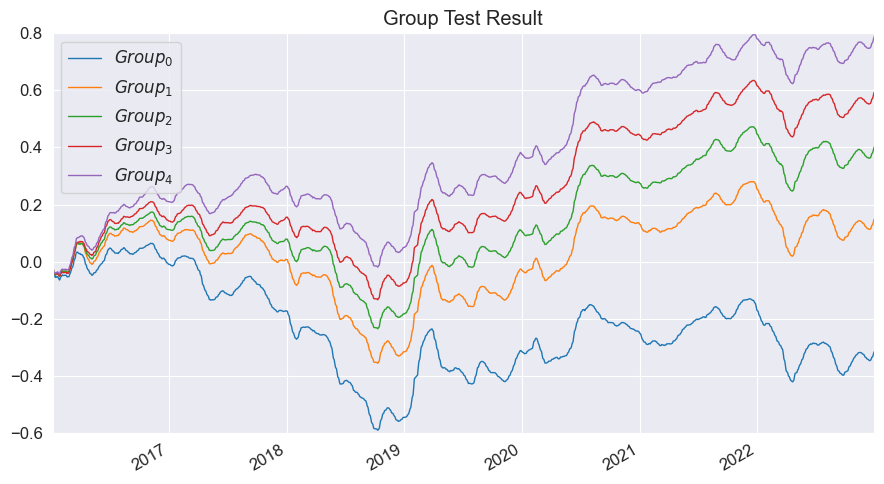

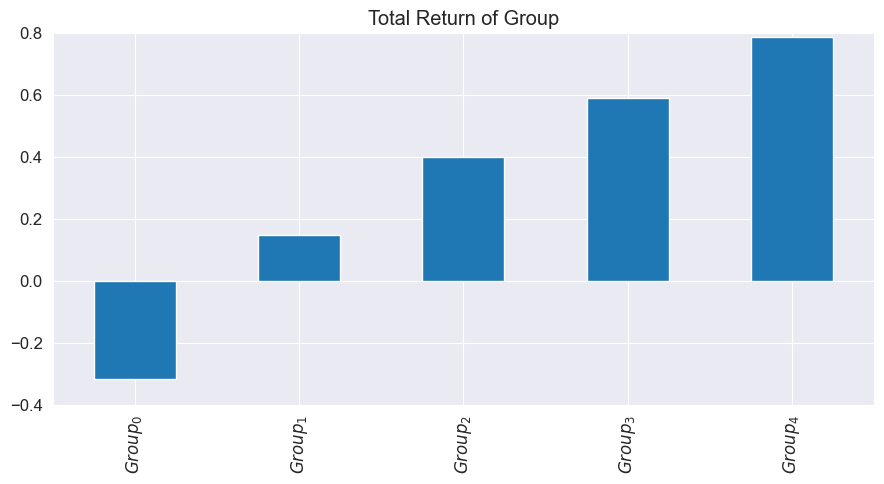

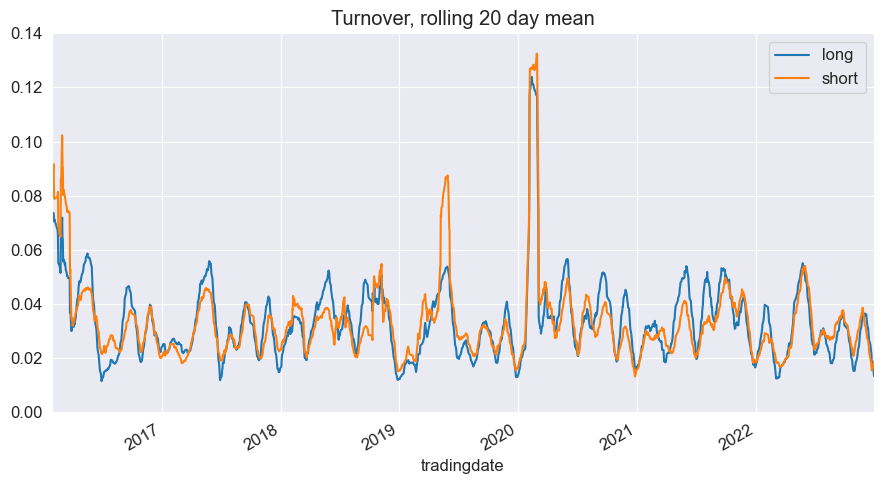

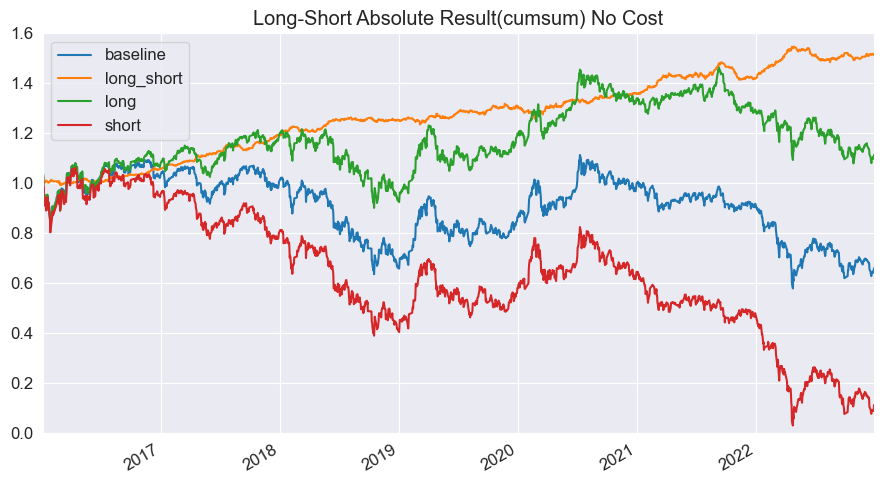

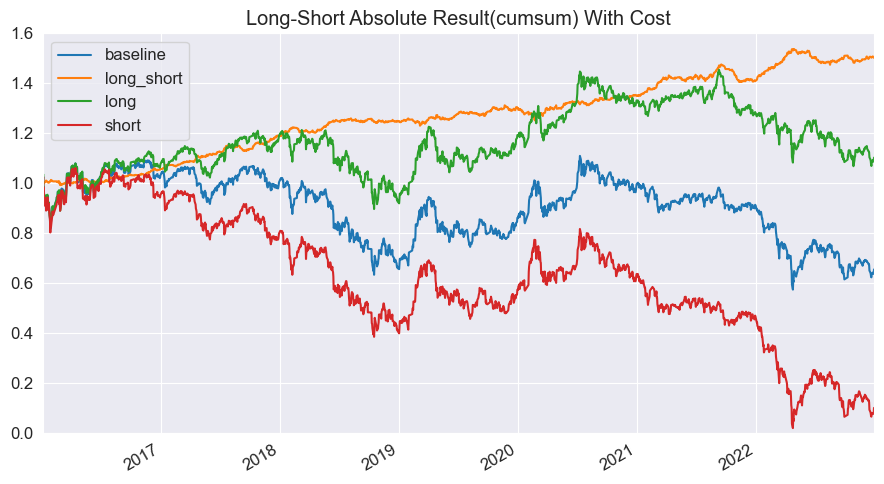

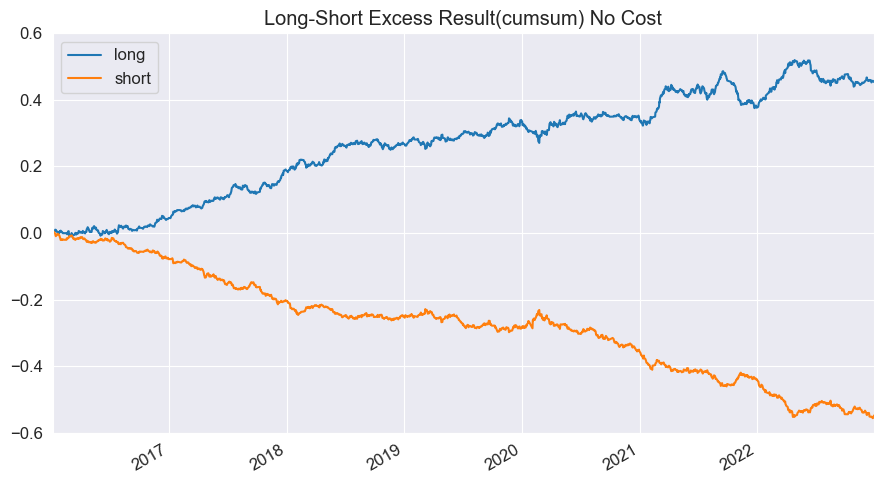

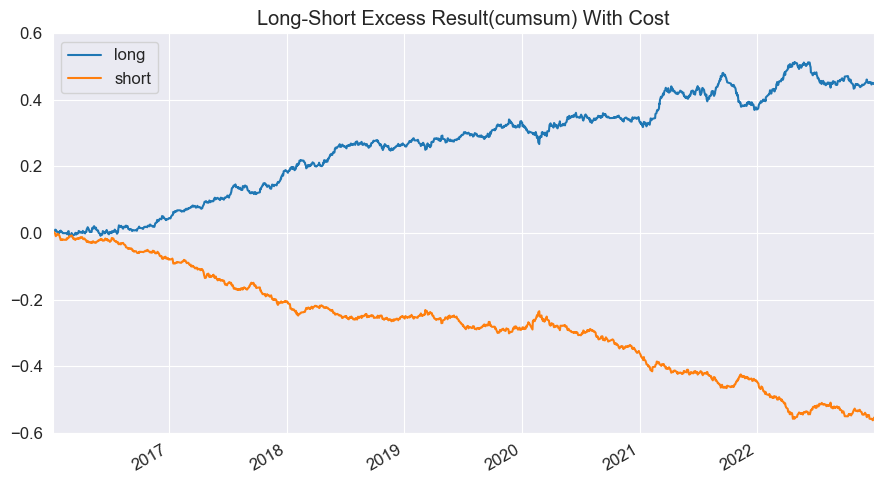

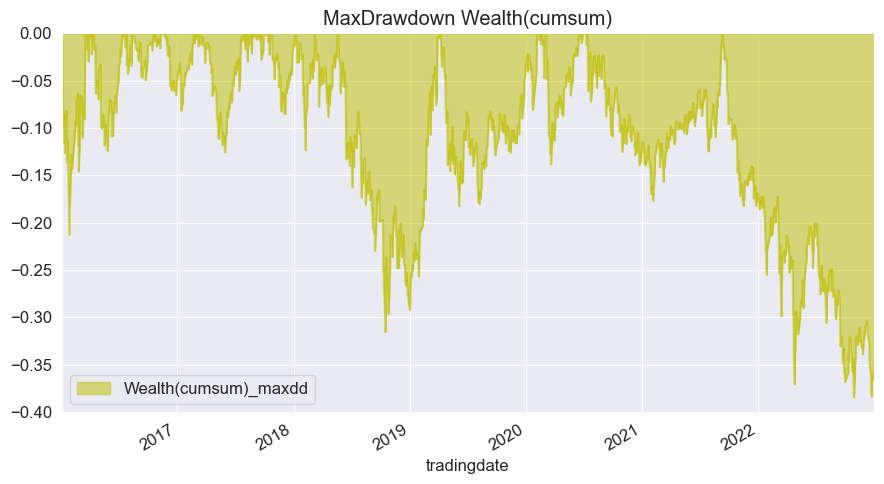

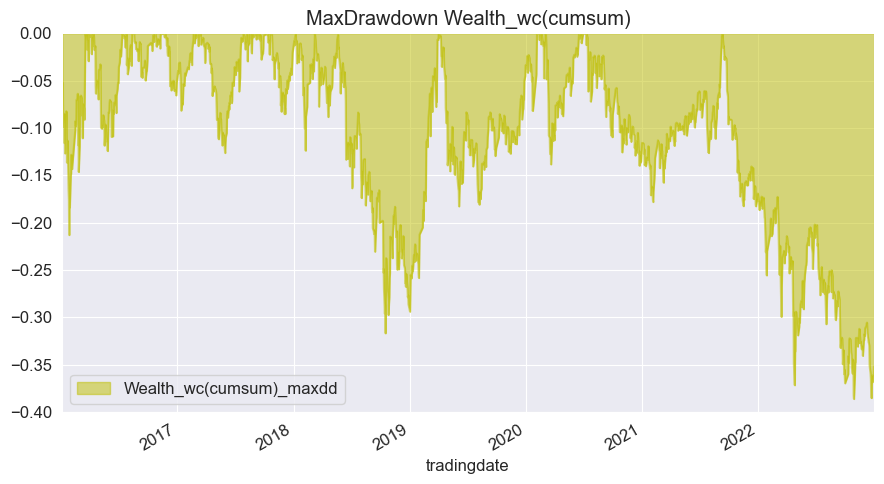

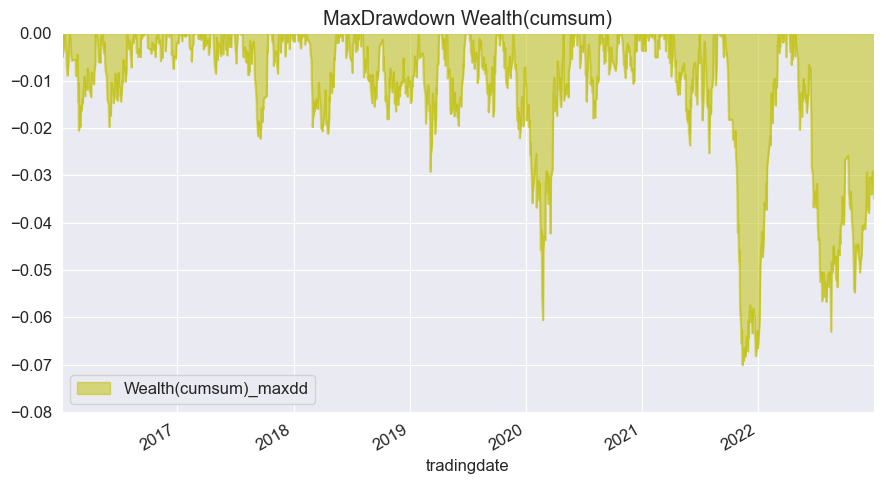

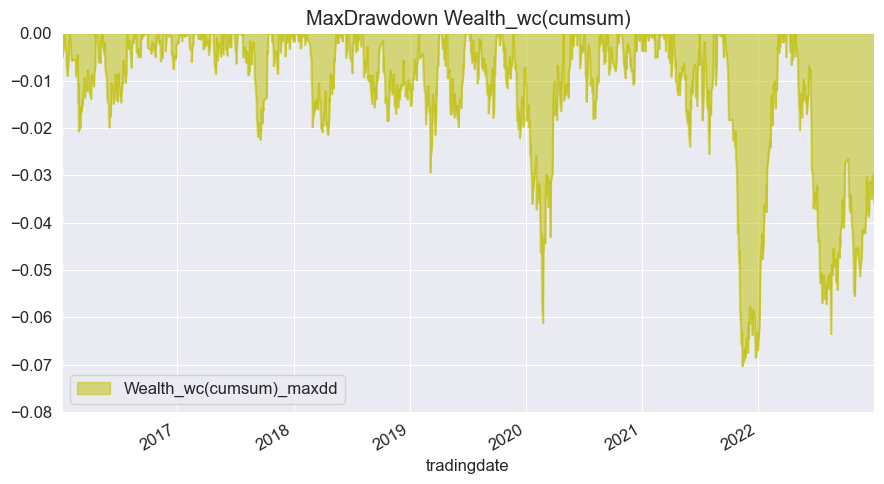

Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Long-short period performance no cost:
                Date  UnitVal   TRet   PRet  PSharpe  PMaxDD  PCalmar  PWinR
SemiYear                                                                    
2016-H1   2016-06-30    1.011  0.011  0.011    0.531  -0.021    0.518  0.458
2016-H2   2016-12-30    1.058  0.058  0.047    3.237  -0.014    3.241  0.573
2017-H1   2017-06-30    1.129  0.129  0.067    4.582  -0.009    7.840  0.588
2017-H2   2017-12-29    1.192  0.192  0.056    3.320  -0.022    2.529  0.552
2018-H1   2018-06-29    1.252  0.252  0.050    3.268  -0.021    2.353  0.571
2018-H2   2018-12-28    1.252  0.252  0.000    0.016  -0.018  

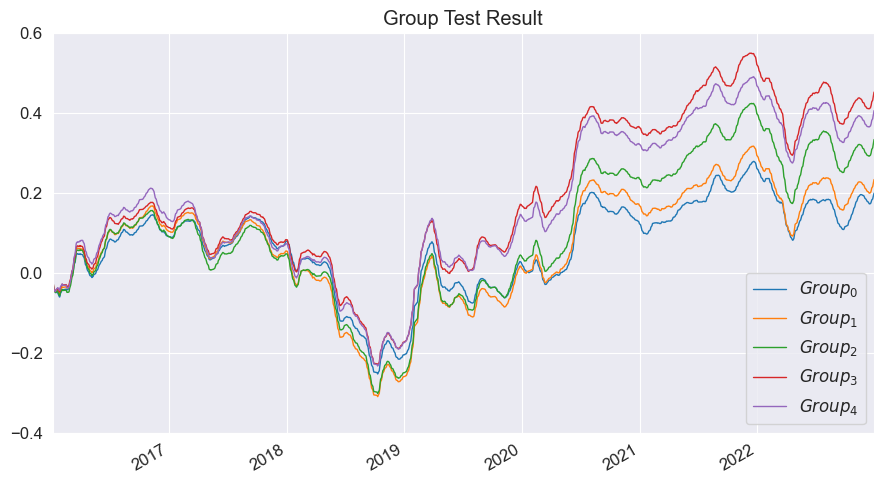

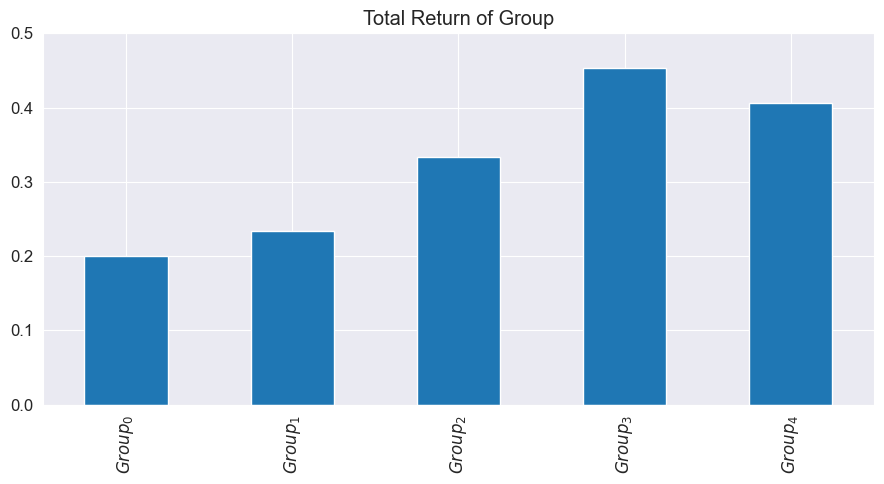

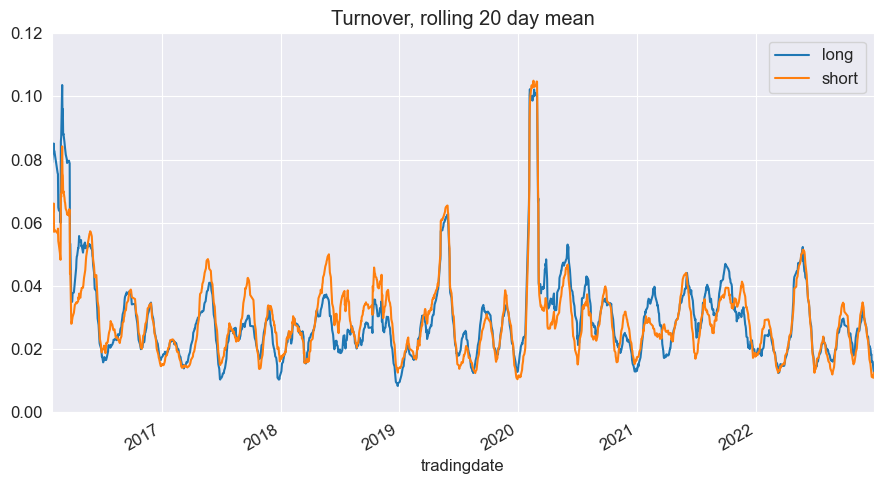

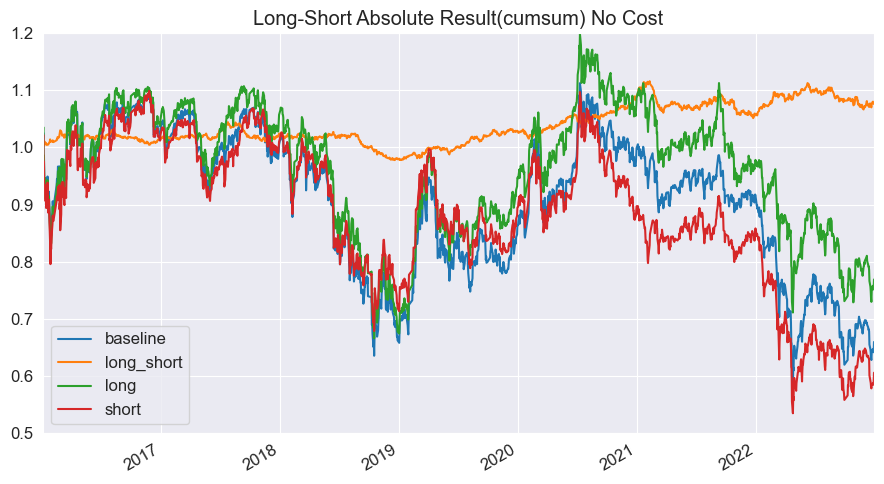

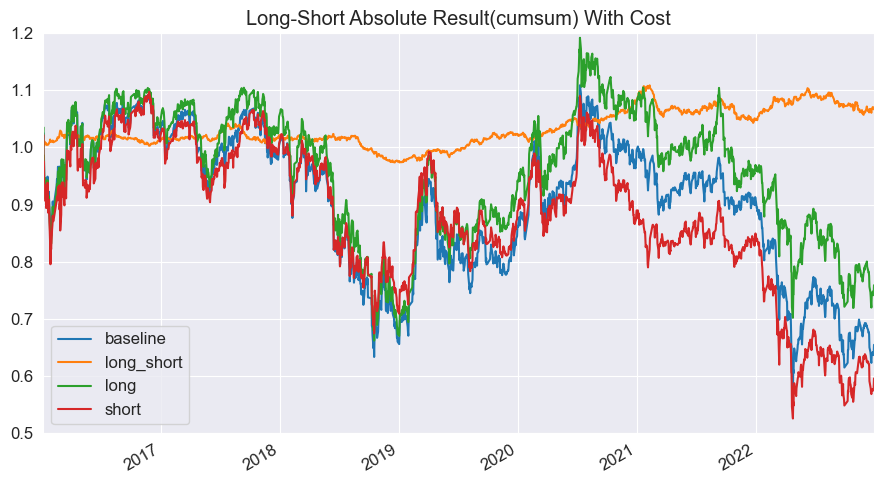

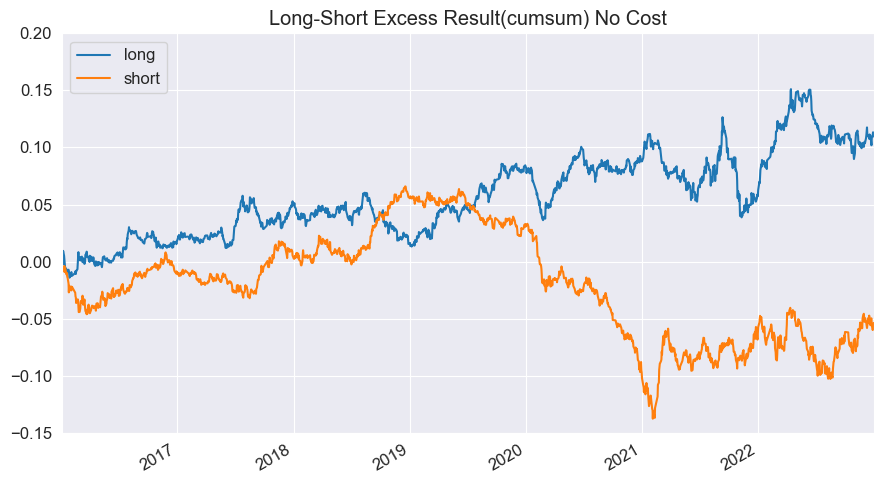

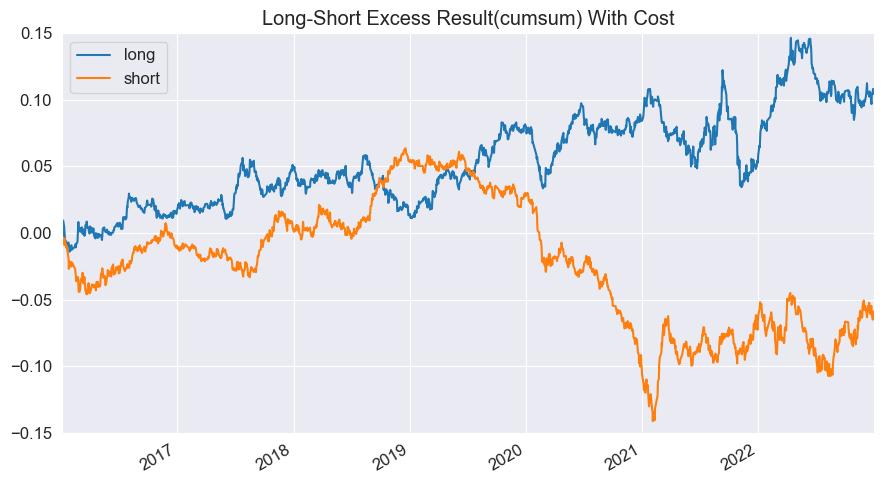

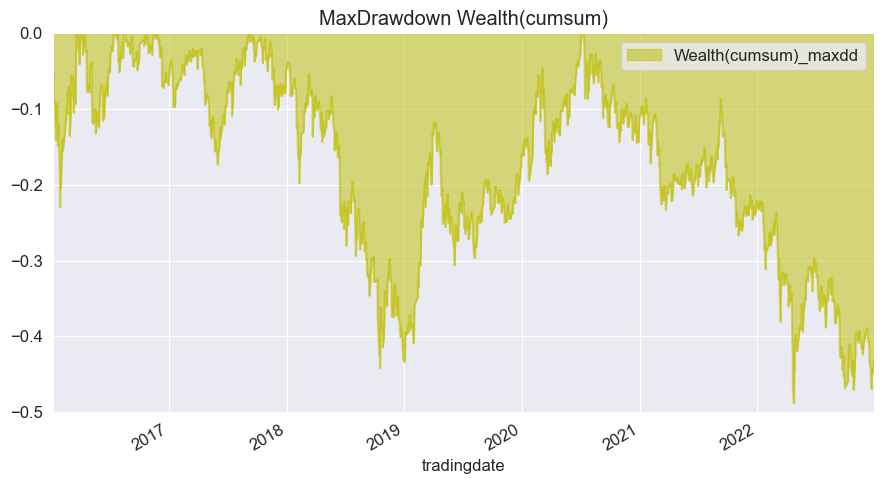

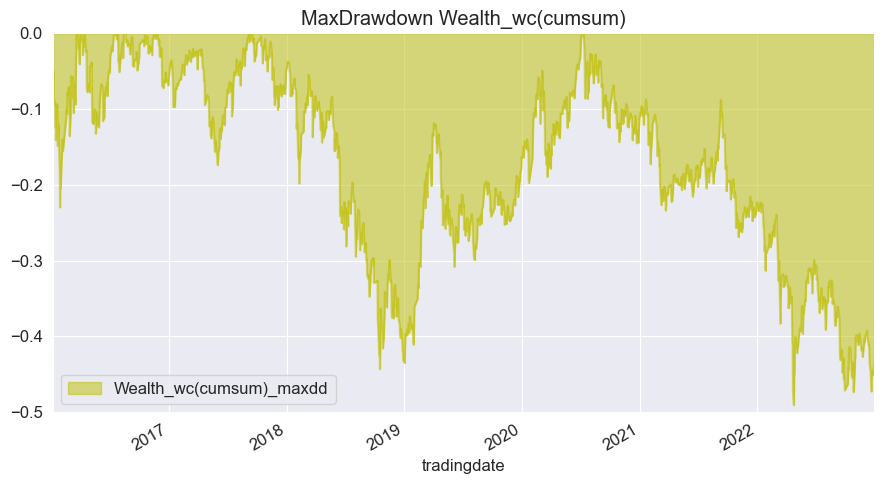

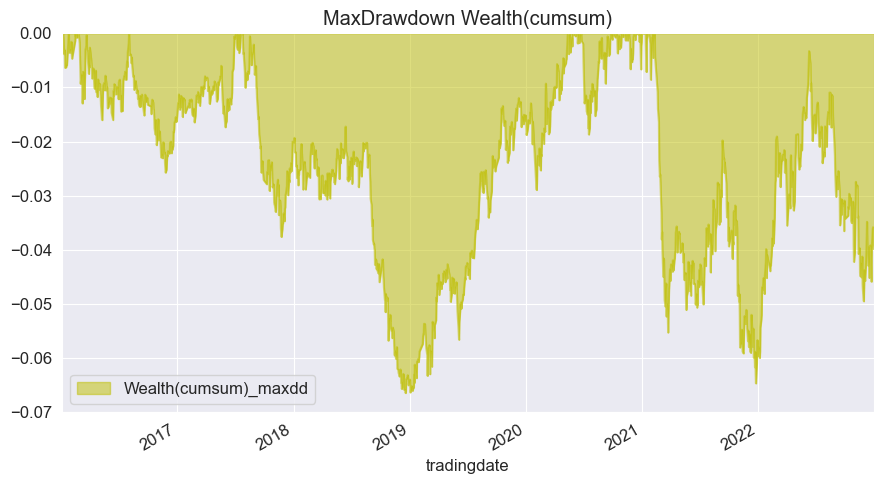

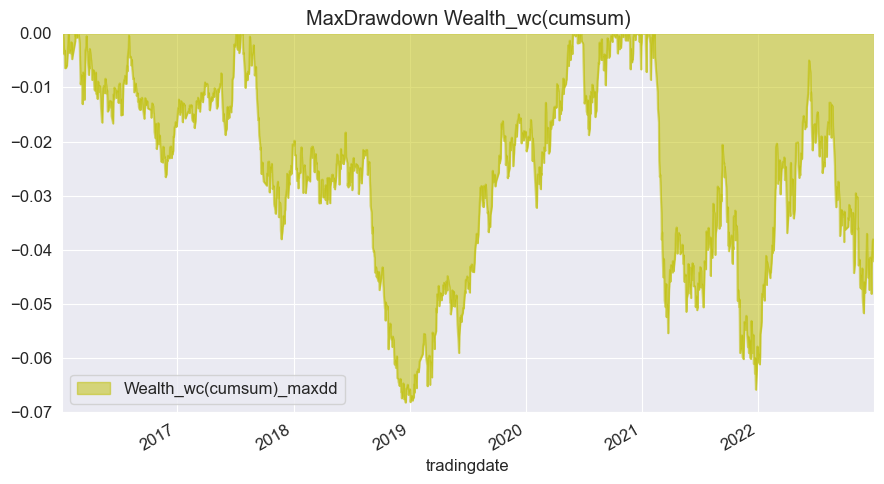

Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Long-short period performance no cost:
                Date  UnitVal   TRet   PRet  PSharpe  PMaxDD  PCalmar  PWinR
SemiYear                                                                    
2016-H1   2016-06-30    1.018  0.018  0.018    1.129  -0.016    1.111  0.483
2016-H2   2016-12-30    1.014  0.014 -0.004   -0.343  -0.026   -0.141  0.508
2017-H1   2017-06-30    1.029  0.029  0.015    1.482  -0.017    0.866  0.555
2017-H2   2017-12-29    1.024  0.024 -0.005   -0.341  -0.038   -0.131  0.512
2018-H1   2018-06-29    1.018  0.018 -0.006   -0.418  -0.031   -0.200  0.496
2018-H2   2018-12-28    0.979 -0.021 -0.038   -2.907  -0.066  

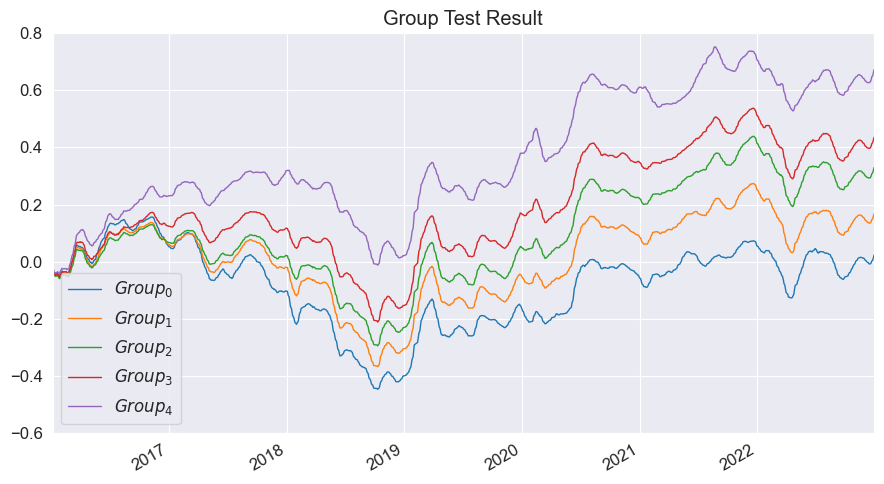

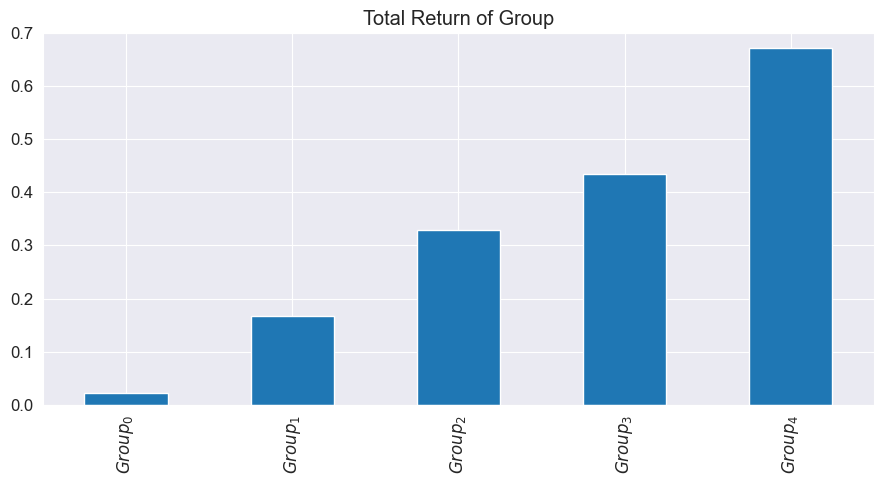

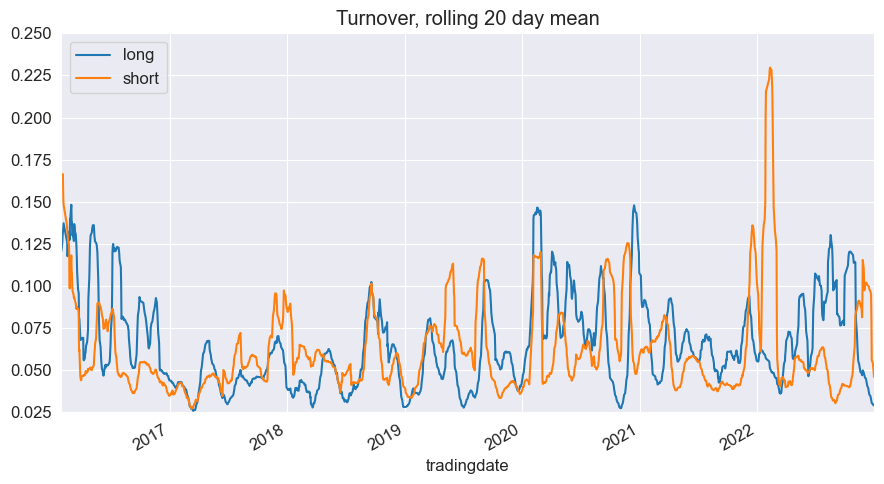

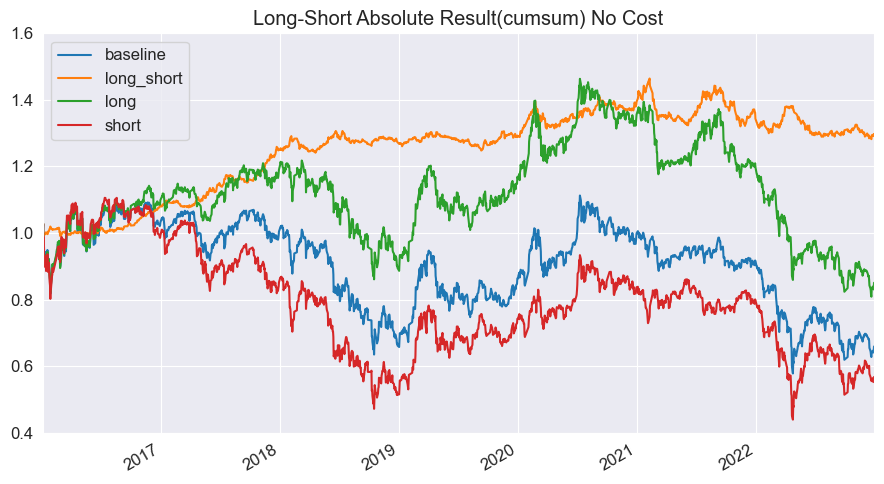

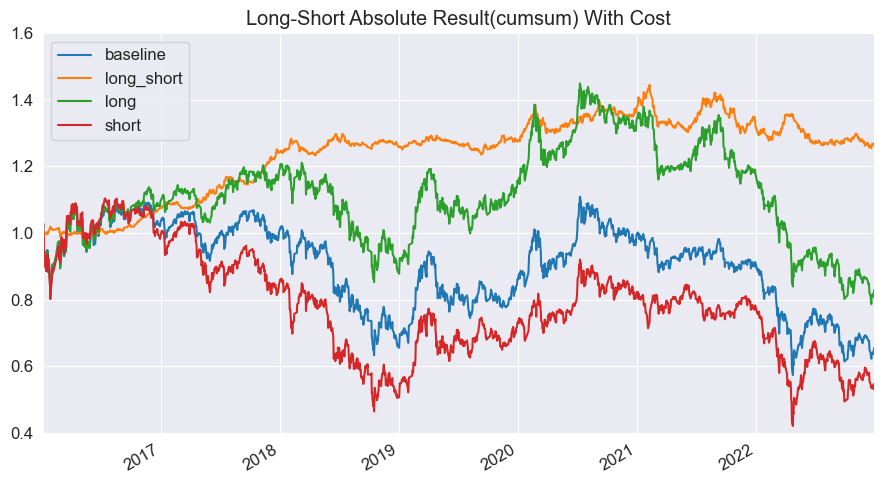

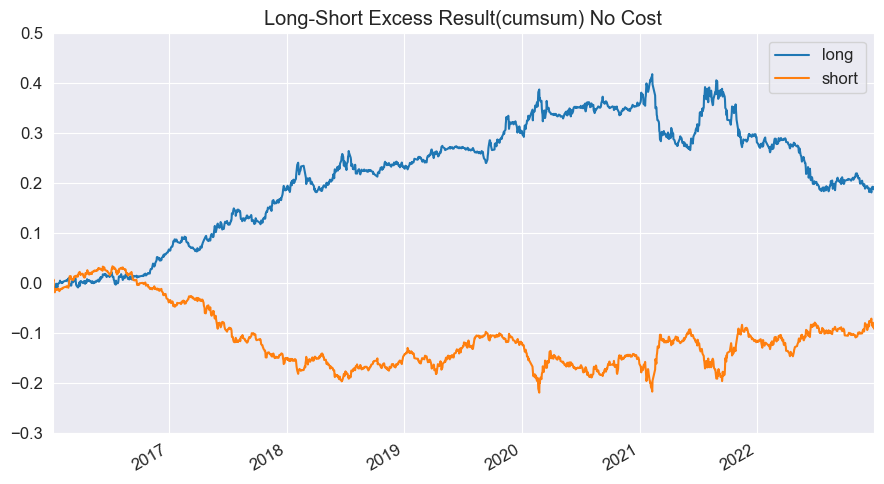

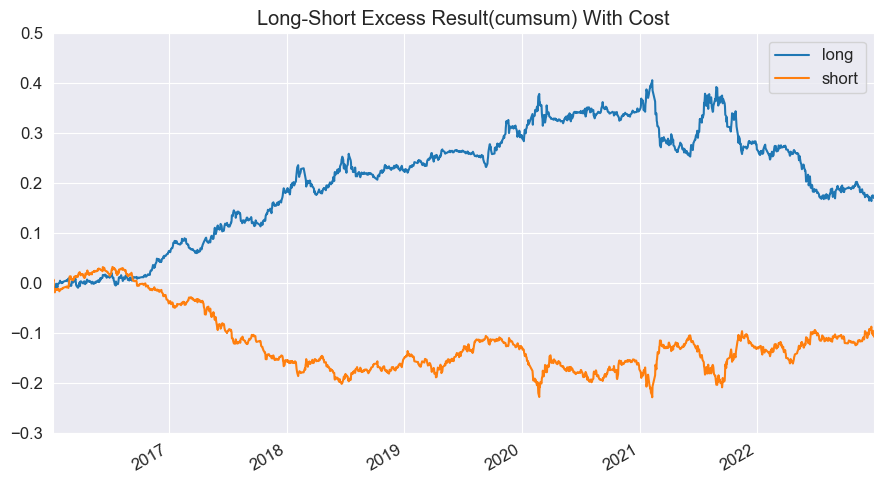

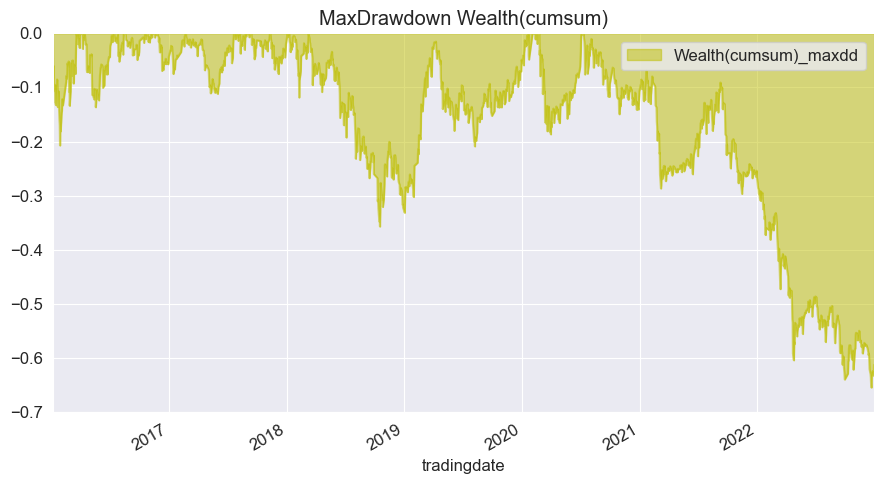

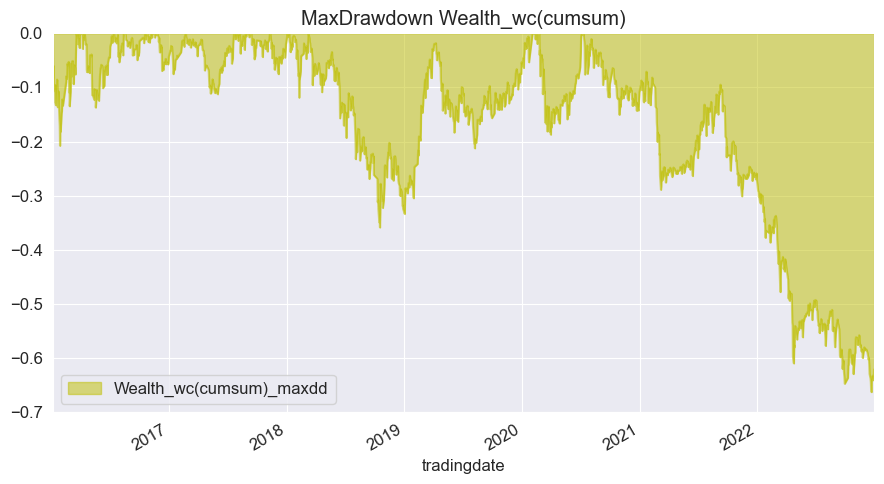

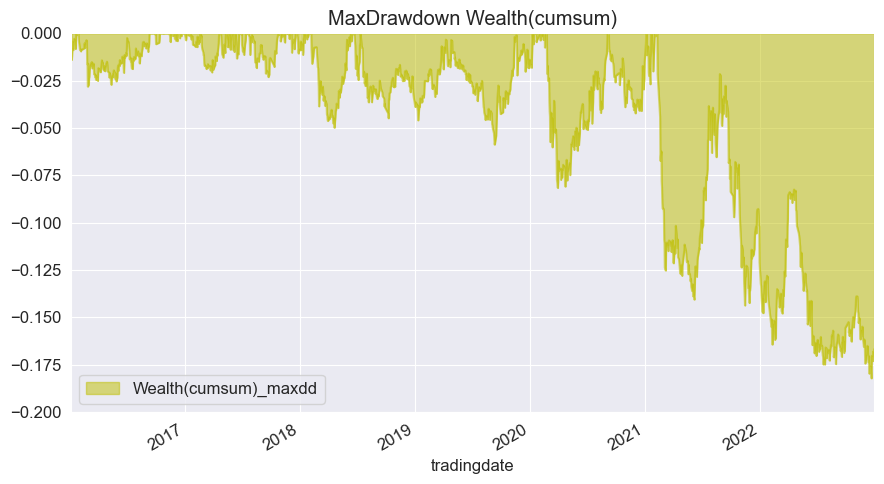

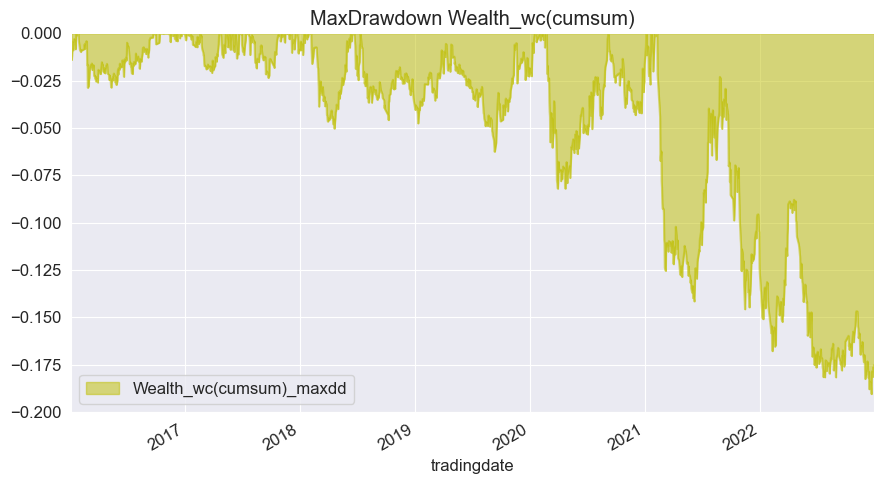

Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Long-short period performance no cost:
                Date  UnitVal   TRet   PRet  PSharpe  PMaxDD  PCalmar  PWinR
SemiYear                                                                    
2016-H1   2016-06-30    1.017  0.017  0.017    0.695  -0.028    0.607  0.517
2016-H2   2016-12-30    1.083  0.083  0.065    4.087  -0.019    3.456  0.677
2017-H1   2017-06-30    1.144  0.144  0.057    2.287  -0.021    2.742  0.513
2017-H2   2017-12-29    1.250  0.250  0.092    3.746  -0.023    3.987  0.568
2018-H1   2018-06-29    1.294  0.294  0.036    1.477  -0.050    0.715  0.588
2018-H2   2018-12-28    1.273  0.273 -0.017   -0.844  -0.045  

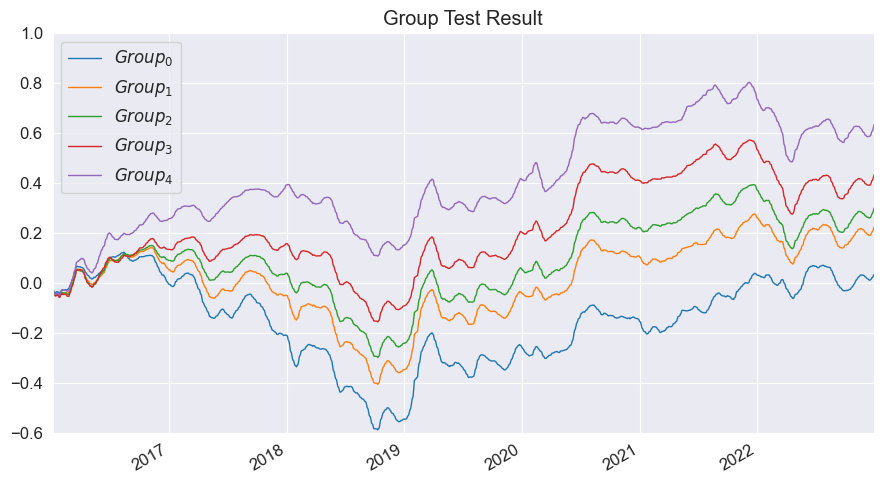

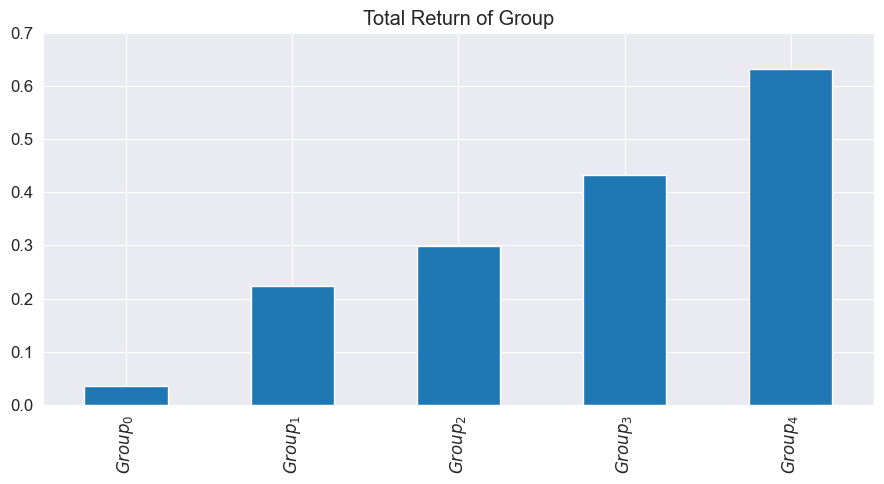

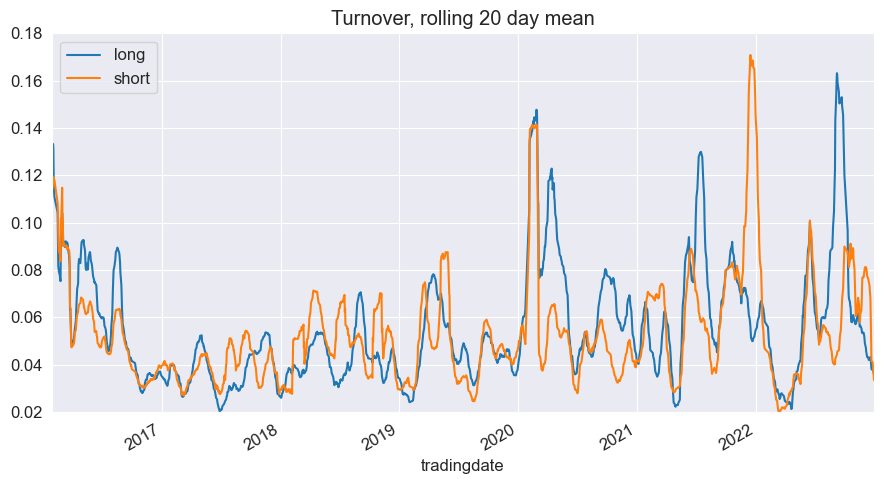

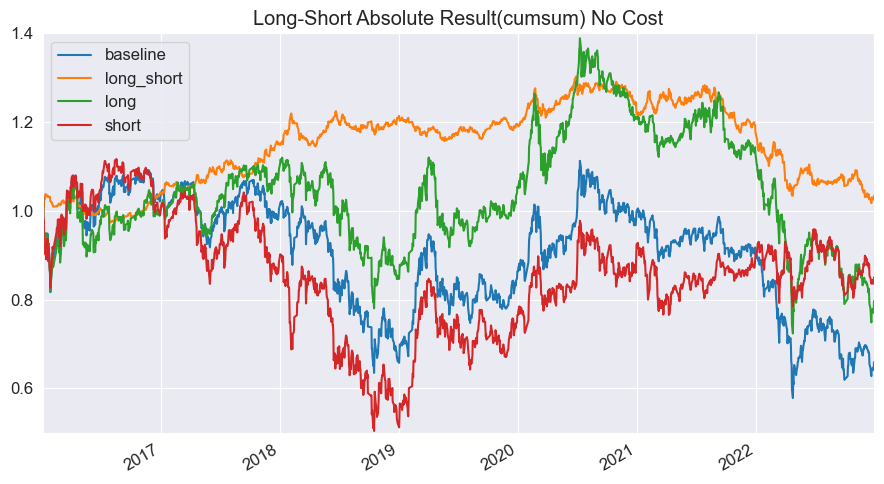

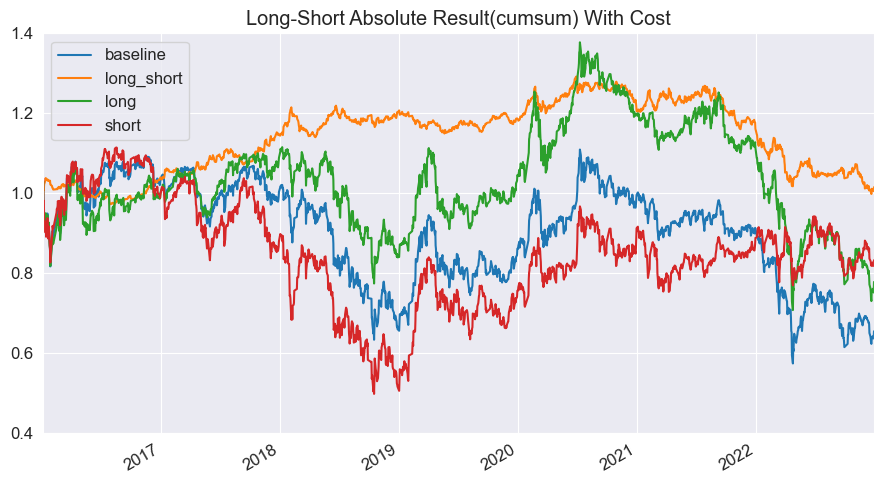

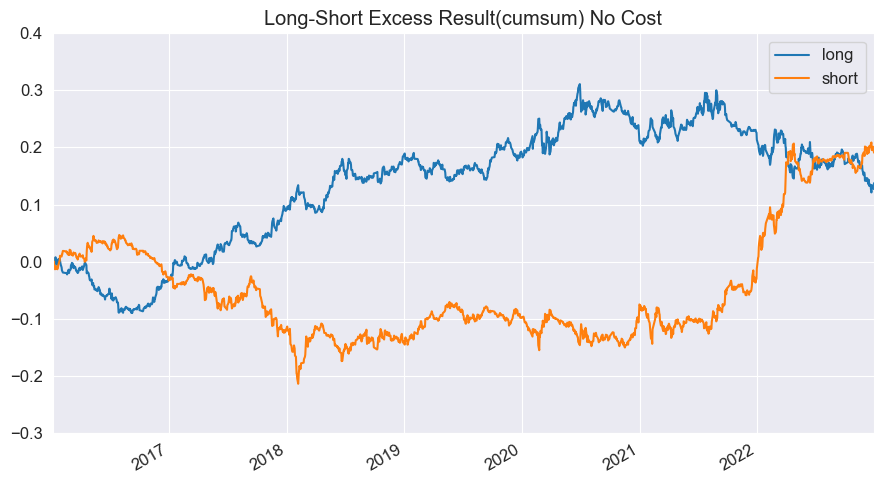

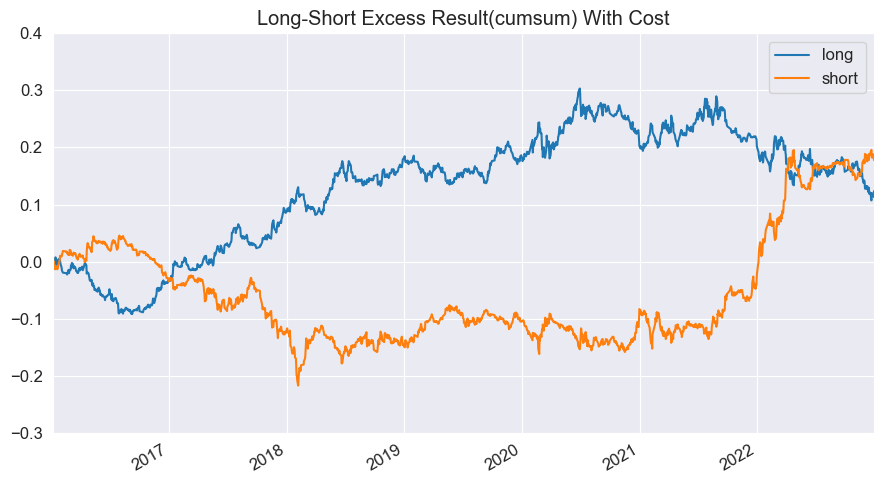

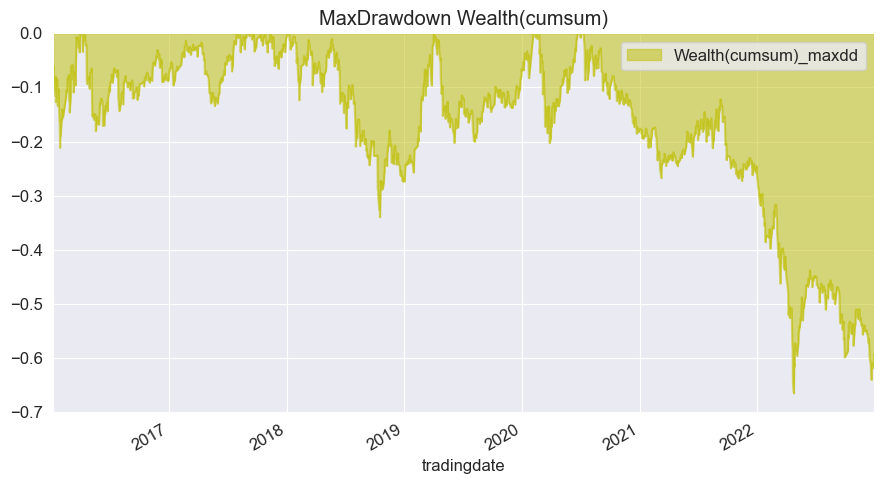

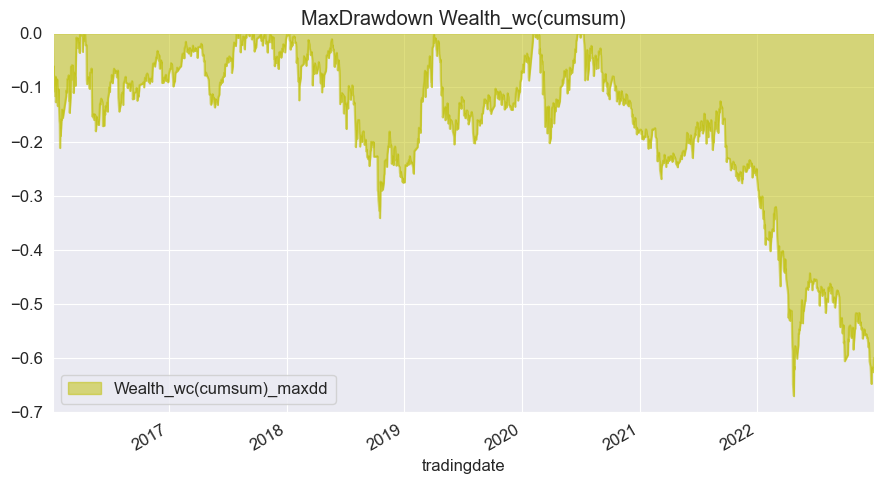

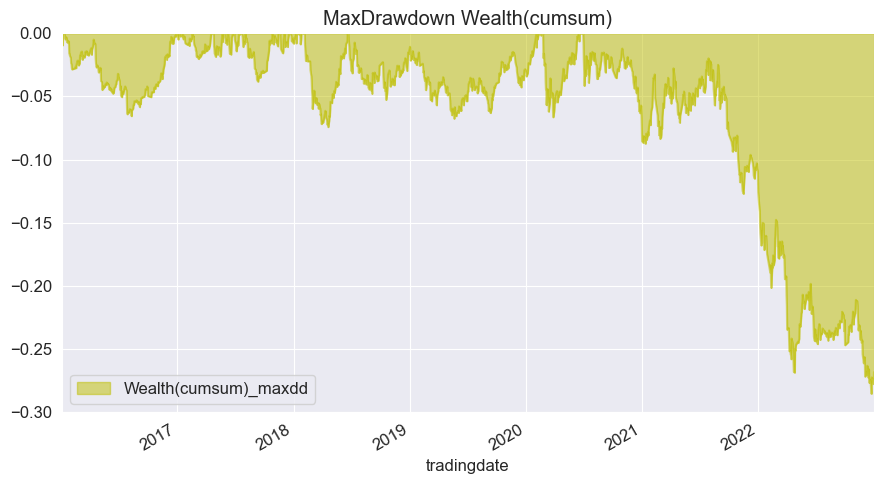

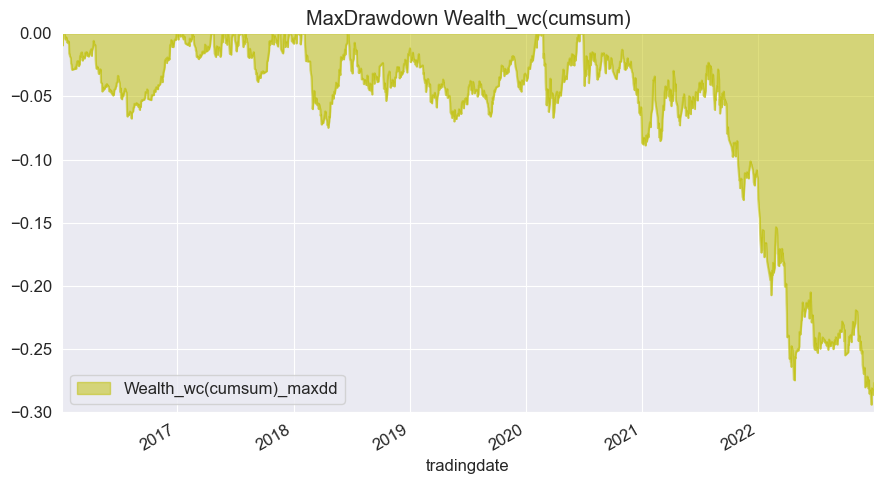

Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Long-short period performance no cost:
                Date  UnitVal   TRet   PRet  PSharpe  PMaxDD  PCalmar  PWinR
SemiYear                                                                    
2016-H1   2016-06-30    1.003  0.003  0.003    0.095  -0.048    0.058  0.492
2016-H2   2016-12-30    1.042  0.042  0.039    1.983  -0.066    0.596  0.589
2017-H1   2017-06-30    1.096  0.096  0.052    1.882  -0.020    2.539  0.538
2017-H2   2017-12-29    1.150  0.150  0.049    1.768  -0.038    1.294  0.480
2018-H1   2018-06-29    1.204  0.204  0.047    1.563  -0.074    0.634  0.529
2018-H2   2018-12-28    1.208  0.208  0.003    0.130  -0.053  

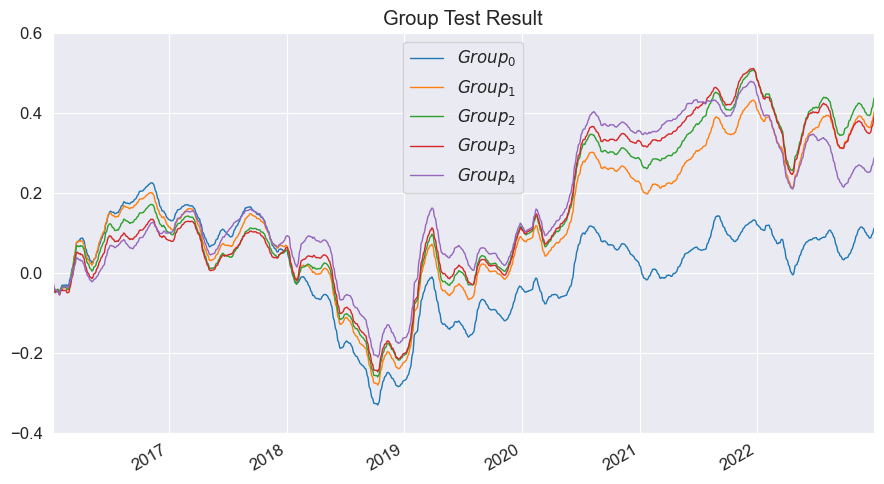

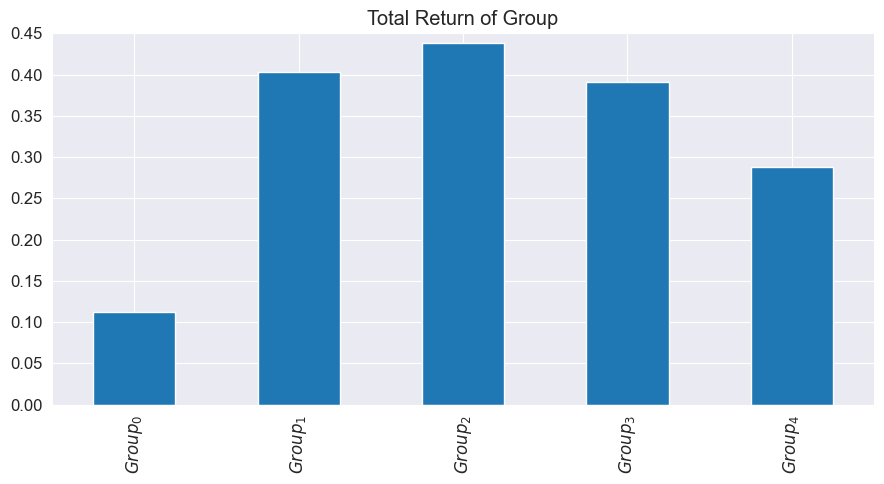

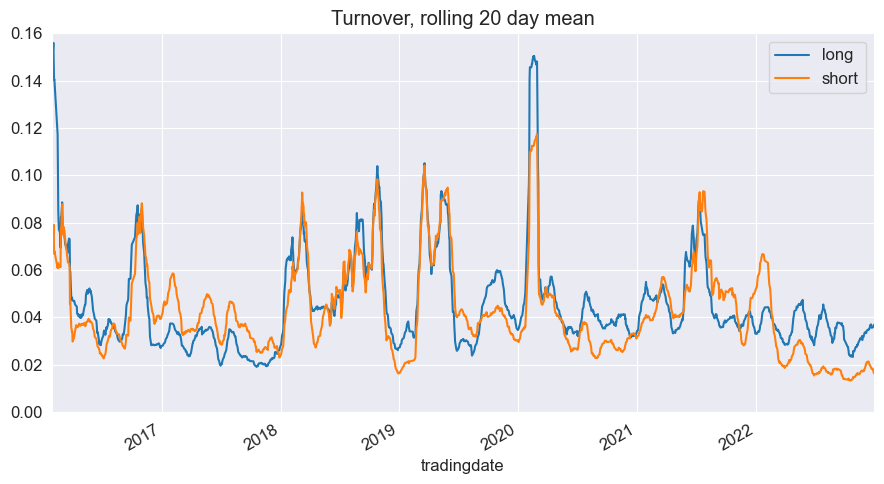

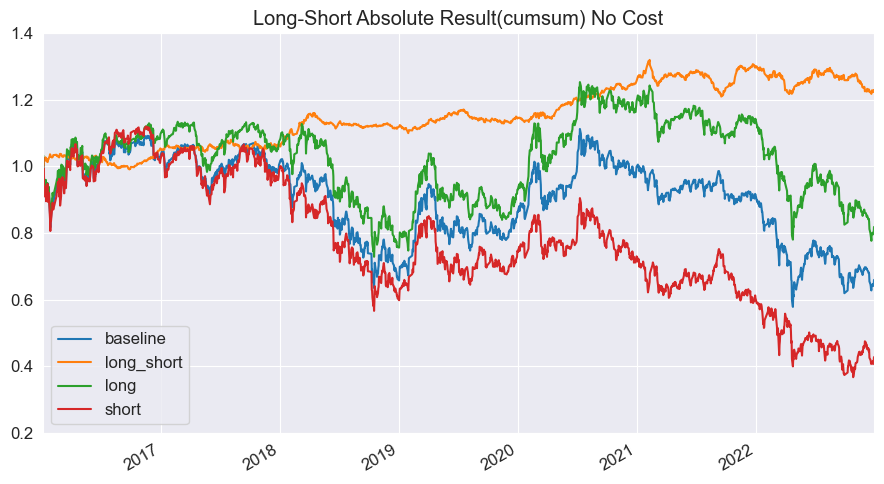

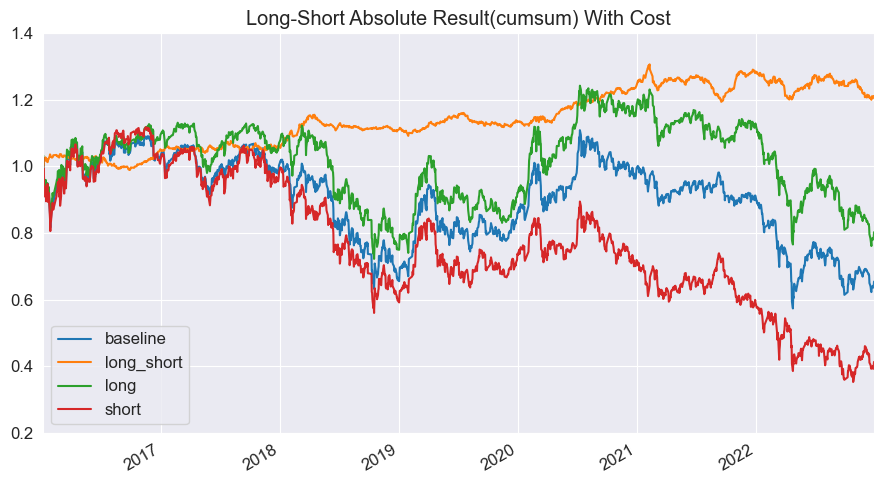

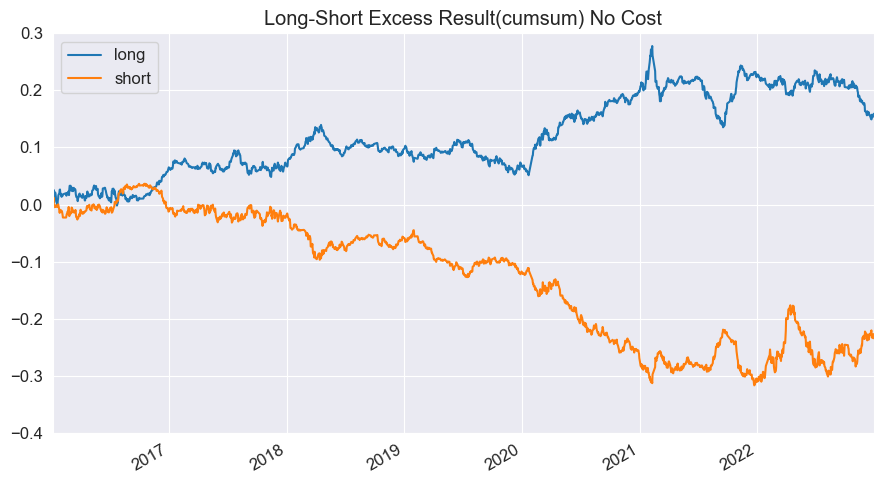

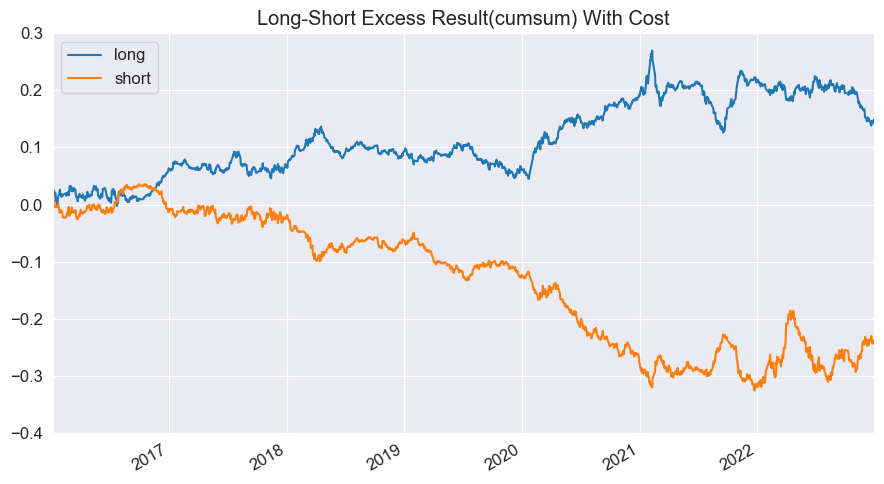

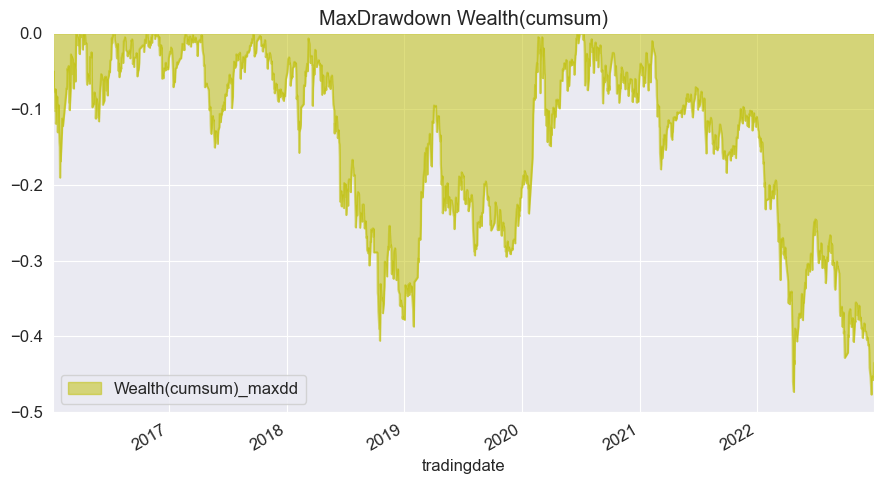

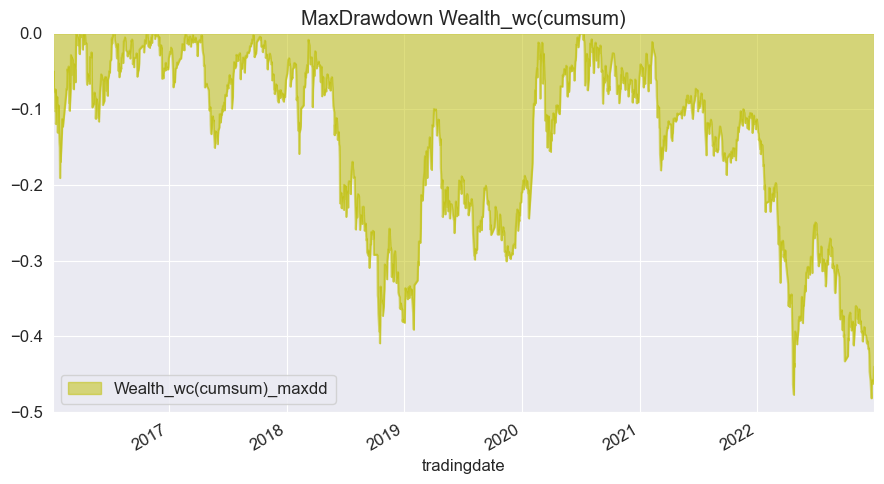

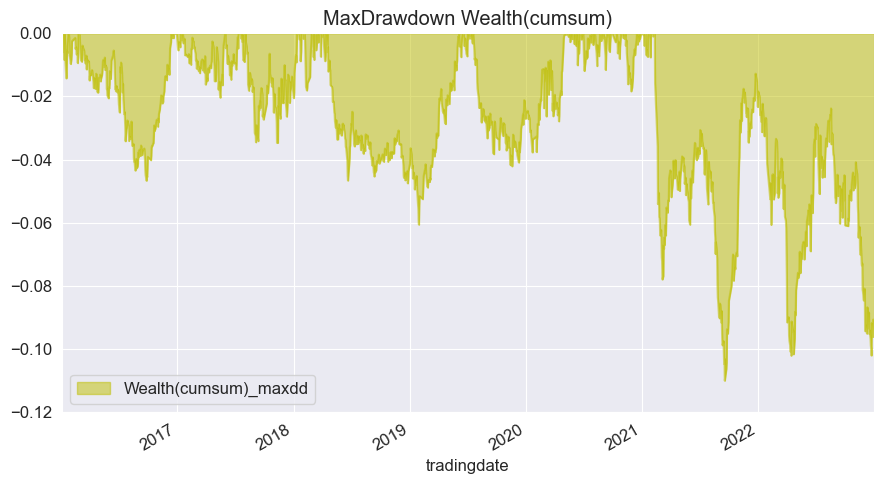

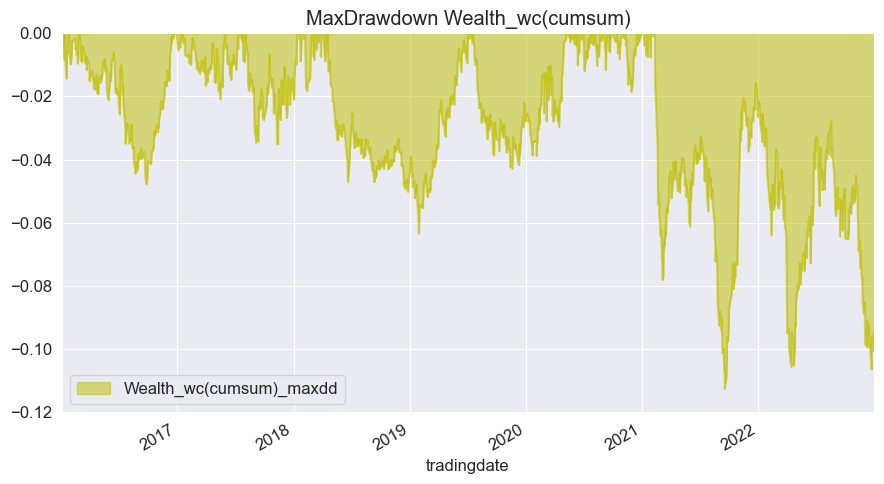

Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Long-short period performance no cost:
                Date  UnitVal   TRet   PRet  PSharpe  PMaxDD  PCalmar  PWinR
SemiYear                                                                    
2016-H1   2016-06-30    1.018  0.018  0.018    0.616  -0.021    0.863  0.492
2016-H2   2016-12-30    1.054  0.054  0.036    1.909  -0.047    0.770  0.605
2017-H1   2017-06-30    1.057  0.057  0.003    0.156  -0.020    0.145  0.513
2017-H2   2017-12-29    1.063  0.063  0.006    0.203  -0.035    0.163  0.488
2018-H1   2018-06-29    1.128  0.128  0.061    2.251  -0.047    1.312  0.563
2018-H2   2018-12-28    1.117  0.117 -0.010   -0.764  -0.048  

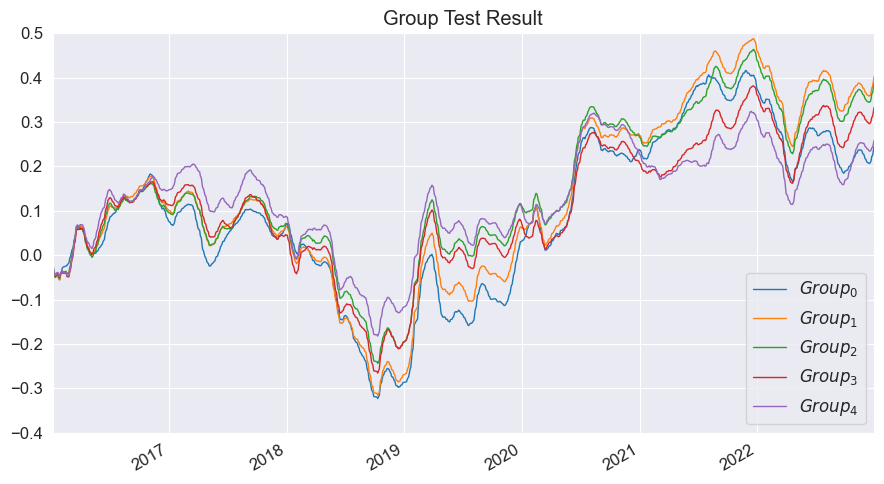

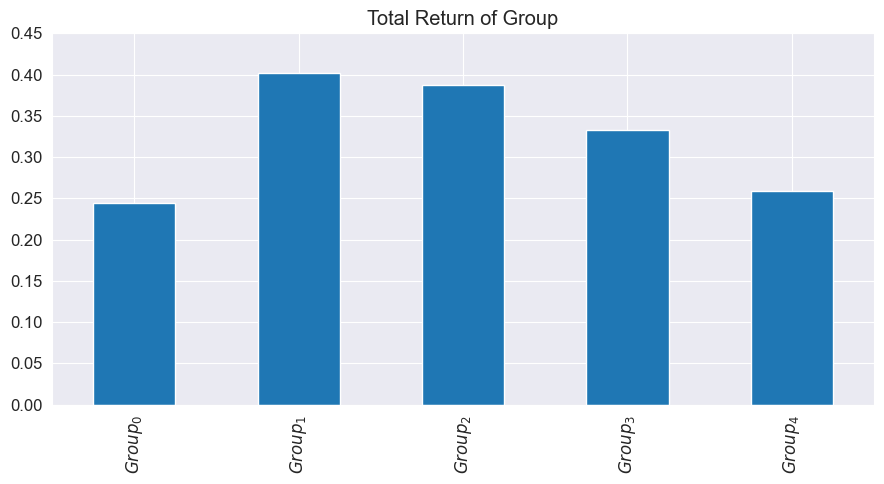

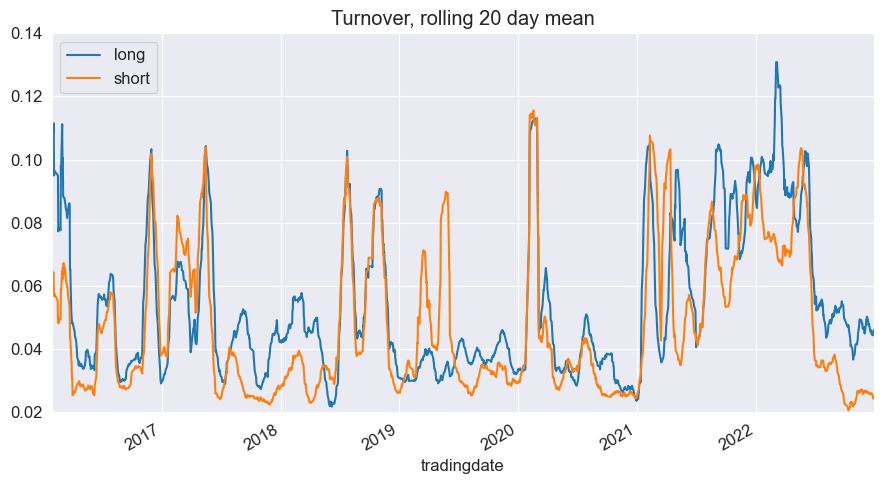

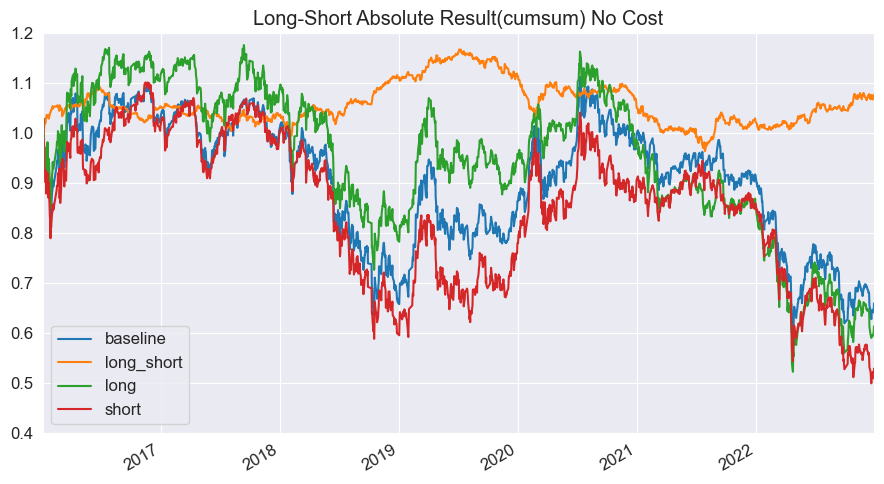

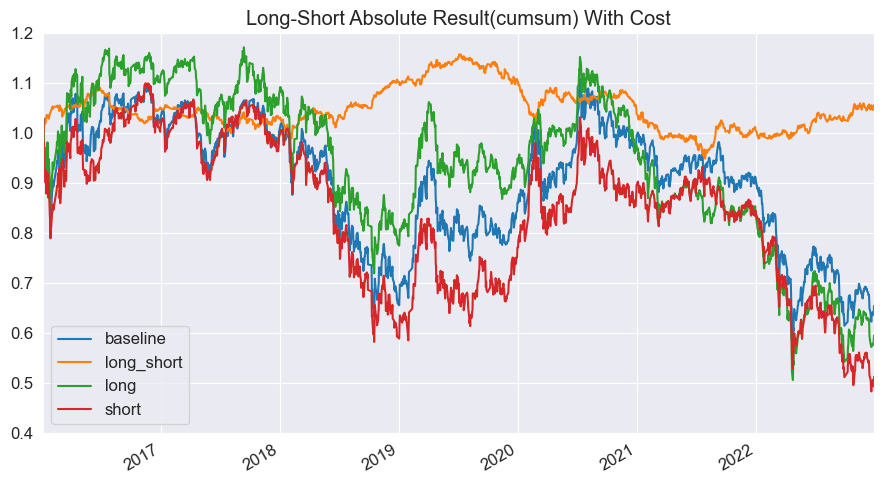

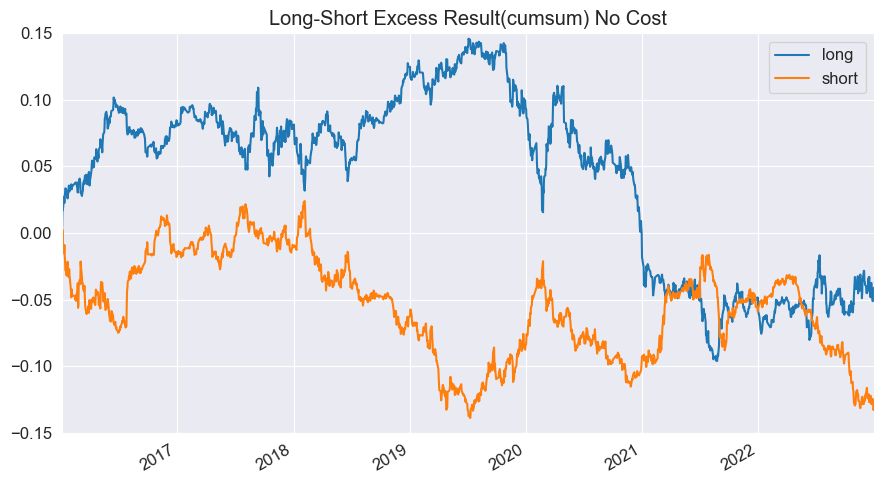

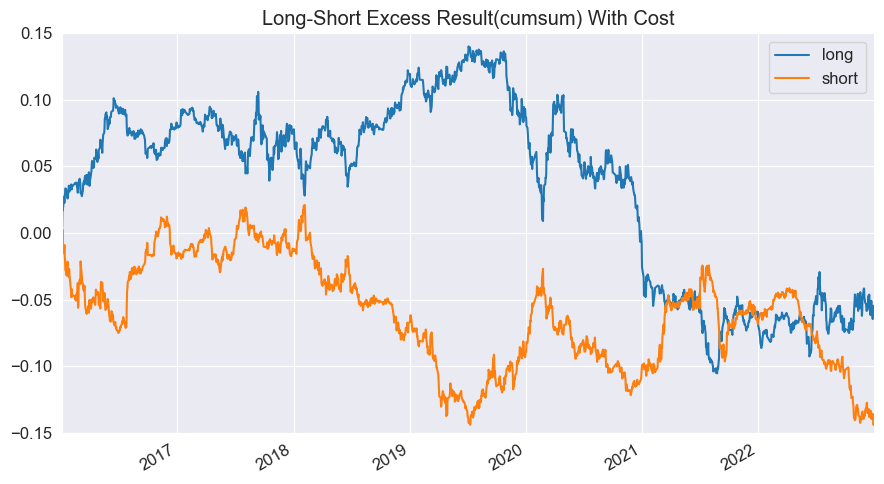

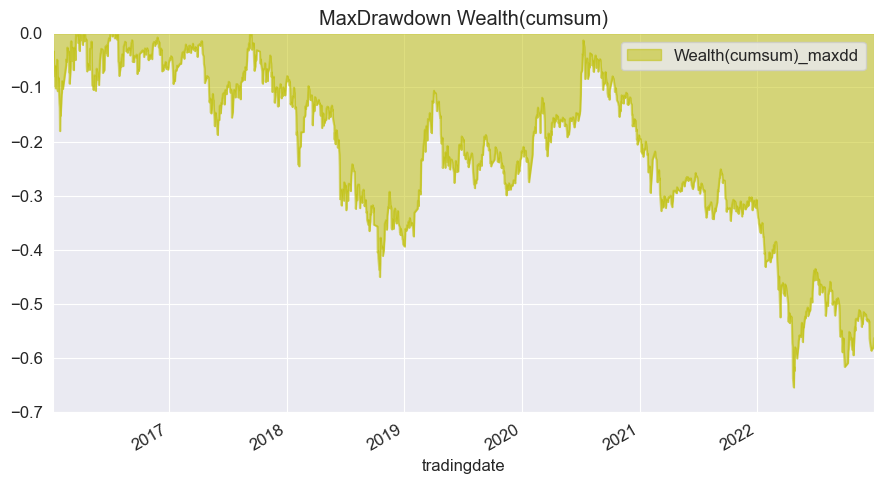

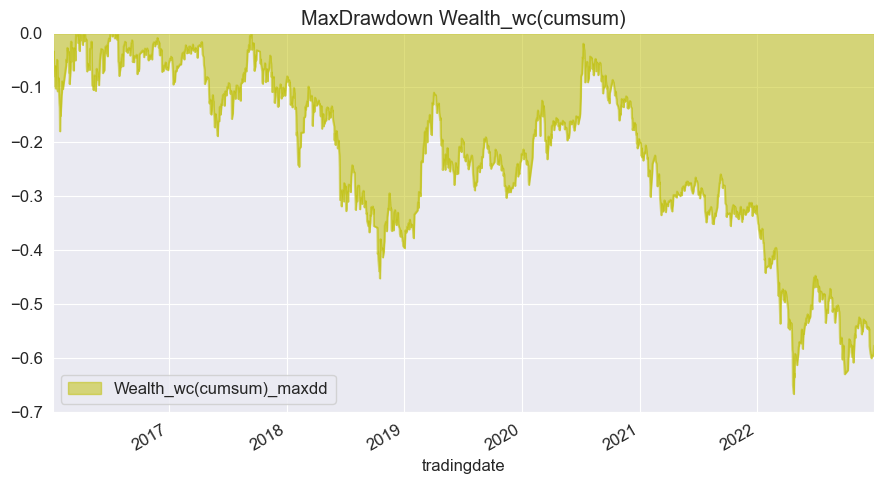

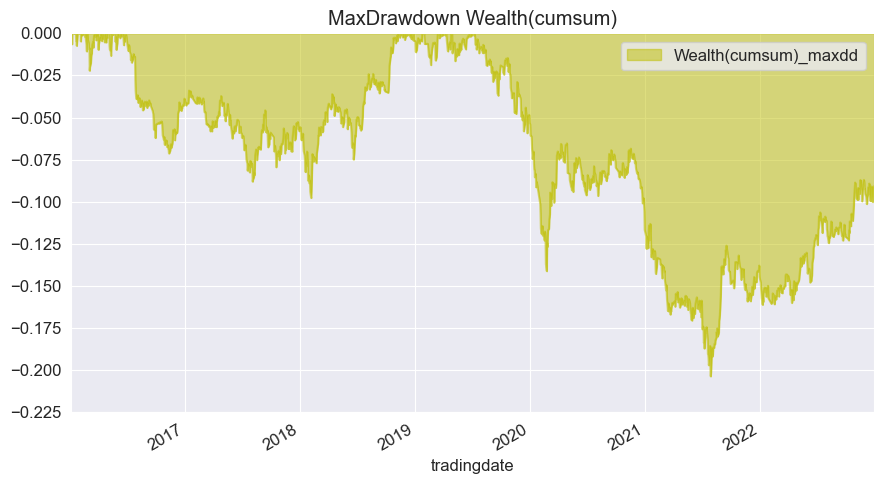

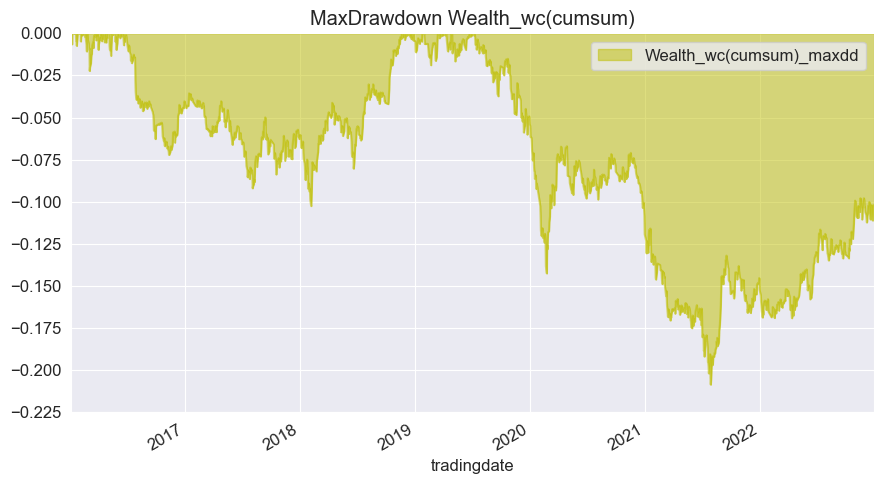

Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Calculate half-year statistics before get_half_year_stat...
Long-short period performance no cost:
                Date  UnitVal   TRet   PRet  PSharpe  PMaxDD  PCalmar  PWinR
SemiYear                                                                    
2016-H1   2016-06-30    1.087  0.087  0.087    2.898  -0.022    3.940  0.592
2016-H2   2016-12-30    1.054  0.054 -0.031   -1.548  -0.071   -0.432  0.508
2017-H1   2017-06-30    1.031  0.031 -0.022   -1.226  -0.063   -0.350  0.479
2017-H2   2017-12-29    1.035  0.035  0.004    0.133  -0.088    0.043  0.536
2018-H1   2018-06-29    1.041  0.041  0.007    0.225  -0.098    0.066  0.479
2018-H2   2018-12-28    1.112  0.112  0.068    3.533  -0.058  

In [11]:
from api.backtester import get_ic_stat, cal_cum_ic
import api.backtester as backtester

import importlib
importlib.reload(backtester)

group_n = 5  # 多空分组
rtns20 = rtn_ct20c / 20  # 评估分组表现的收益率
rtns1d = rtn_ct1c  # 评估组合表现的单日收益率
ishow = True  # 是否展示图片
idx_weight = idx_wei_500  # 基准股池
cond_list = [new_share, updown_status, suspend_d, st_status]  # 停用股


t = 1 if _FACTOR_POOL >= 3 else 2
cache_strategies = {}
cache_compare = []
cache_compare_wc = []
for t in range(t, len(fnames)):
    print('='*12, f"{t-1}/{len(fnames)-2}", fnames[t], '='*12)
    
    fval_raw = get_factor_value_(t, begin_date, end_date, fnames[t], code_dict)
    print(f"F_VAL: get {len(fval_raw)} rows from {begin_date} to {end_date}.")
    
    ### 存储地址
    path_format = conf['path']['factors_res']  + prefix + fnames[t] + f'[{_VERSION}]/'
    os.makedirs(path_format, exist_ok=True)
    path_format += '{}'
    print(f"RES: save results in `{path_format.format('')}`.")
    
    
    ### 因子值情况统计
    fval_stat = pd.DataFrame()
    fval_stat['count_raw'] = fval_raw.count(axis=1).astype(int)

    fval = fval_raw.copy()

    fval = fval.replace(0, np.nan)
    fval_stat['count_dropna'] = fval.count(axis=1).astype(int)

    fval = sift_tradeable_matrics(left=fval, cond_list=cond_list)
    fval_stat['count_tradeable'] = (fval.count(axis=1).astype(int))
    fval_stat['coverage_tradeable'] = (fval_stat['count_tradeable'] / daily_tradeable_count)

    print(fval_stat.describe().round(3))
    fval_stat.to_csv(path_format.format('因子值情况统计.csv'))
    
    del fval_stat, fval_raw

    
    ### 因子预处理
    # 因为wry给因子没有极值，只需重新标准化到截面 N(0, 1)
    fval = fval.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
    

    ### 因子评估：IC
    ic_stat_rank = get_ic_stat(left=fval, rtns=rtn_dict, ranked=True, save_path=path_format.format('截面RankIC.csv'))
    ic_stat = get_ic_stat(left=fval, rtns=rtn_dict, ranked=False, save_path=path_format.format('截面IC.csv'))
    cal_cum_ic(ic_stat_rank, save_path=path_format.format('累积RankIC.csv'), plot_path=path_format.format('累积RankIC.png'), ishow=False, ylen=conf['year_length'])
    cal_cum_ic(ic_stat, save_path=path_format.format('累积IC.csv'), plot_path=path_format.format('累积IC.png'), ishow=False, ylen=conf['year_length'])
    
    
    ### 回测 2.0
    rvs_flag = [1, -1][ic_stat_rank.mean().mean() < 0]  # 负IC：反转因子
    signal = backtester.Signal(data=fval * rvs_flag, neu='n')
    del fval
    
    strategy = backtester.Strategy(sgn=signal, ng=group_n)
    strategy.cal_long_short_group()
    strategy.cal_group_returns(rtns20, idx_w=None)  # 用20日持仓收益率衡量多空分组收益率；且在全市场评估分组收益率
    strategy.get_ls_group(path_format.format('LSGroup.csv'))
    strategy.get_group_returns(path_format.format('GroupRtns.csv'))
    strategy.plot_group_returns(ishow, path_format.format('ResGroup.png'))
    strategy.plot_group_returns_total(ishow, path_format.format('TotalRtnsGroup.png'))
    strategy.cal_long_short_panels(idx_w=idx_weight, hd=20, rvs=False, cr=2e-4, ret=rtns1d)  # 评估分组表现时，用单日收益率，股指为基准，20日持仓

    strategy.plot_long_short_turnover(ishow, path_format.format('LSTurnover.png'), roll=20)
    strategy.plot_cumulative_returns(ishow, path_format.format('LSAbsResNC.png'), False, 'cumsum', False)
    strategy.plot_cumulative_returns(ishow, path_format.format('LSAbsResWC.png'), True, 'cumsum', False)
    strategy.plot_cumulative_returns(ishow, path_format.format('LSExcResNC.png'), False, 'cumsum', True)
    strategy.plot_cumulative_returns(ishow, path_format.format('LSExcResWC.png'), True, 'cumsum', True)
    strategy.portfolio['long'].plot_max_drawdown(ishow, path_format.format('LMddNC.png'), wc=False)
    strategy.portfolio['long'].plot_max_drawdown(ishow, path_format.format('LMddWC.png'), wc=True)
    strategy.portfolio['long_short'].plot_max_drawdown(ishow, path_format.format('LSMddNC.png'), wc=False)
    strategy.portfolio['long_short'].plot_max_drawdown(ishow, path_format.format('LSMddWC.png'), wc=True)

    strategy.get_ls_panels(path_f=path_format)
    for wc in [False, True]:
        strategy.get_portfolio_statistics(kind='long', wc=wc, path_f=path_format)
        strategy.get_portfolio_statistics(kind='short', wc=wc, path_f=path_format)
        strategy.get_portfolio_statistics(kind='long_short', wc=wc, path_f=path_format)
    
    period_indices = ['Date', 'UnitVal', 'TRet', 'PRet', 'PSharpe', 'PMaxDD','PCalmar', 'PWinR']
    total_indices = ['UnitVal', 'TRet', 'TMaxDD', 'TSharpe', 'TCalmar', 'TWinR', 'TAnnRet'] 
    print('Long-short period performance no cost:')
    print(strategy.get_portfolio_statistics(kind='long_short', wc=False)[period_indices].round(3))
    print('Long-short period performance with cost:')
    print(strategy.get_portfolio_statistics(kind='long_short', wc=True)[period_indices].round(3))
    
    tres0 = strategy.get_portfolio_statistics(kind='long_short', wc=False).iloc[-1][total_indices].rename(fnames[t])
    tres1 = strategy.get_portfolio_statistics(kind='long_short', wc=True).iloc[-1][total_indices].rename(fnames[t])
    cache_compare.append(tres0)
    cache_compare_wc.append(tres1)
    print('Long-short whole period performance:')
    print(pd.concat([tres0.rename('No Cost'), tres1.rename('With Cost')], axis=1).T.astype(float).round(3))
    del tres0, tres1
    
    cache_strategies[fnames[t]] = strategy
    del signal, strategy


In [12]:
# 策略结果对比
cache_compare = pd.concat(cache_compare, axis=1).T.astype(float)
cache_compare.to_csv(conf['path']['factors_res'] + f'{prefix}total_stat_nc[{_VERSION},{len(cache_compare)}].csv')
cache_compare.round(3)

UnitVal   TRet  TMaxDD  TSharpe  TCalmar  TWinR  TAnnRet
Average                1.512  0.512  -0.070    1.636   23.347  0.545    0.061
PCA                    1.076  0.076  -0.066    0.324    4.872  0.514    0.010
HistoryFactorReturn    1.297  0.297  -0.182    0.578    3.173  0.529    0.038
HistoryIC              1.034  0.034  -0.285    0.066    0.230  0.506    0.005
MaxICIR                1.229  0.229  -0.110    0.584    5.305  0.514    0.030
MaxIC                  1.073  0.073  -0.204    0.189    0.926  0.507    0.010

In [13]:
# 策略结果对比，手续费单边千二（双边千四）
cache_compare_wc = pd.concat(cache_compare_wc, axis=1).T.astype(float)
cache_compare_wc.to_csv(conf['path']['factors_res'] + f'{prefix}total_stat_wc[{_VERSION},{len(cache_compare_wc)}].csv')
cache_compare_wc.round(3)

UnitVal   TRet  TMaxDD  TSharpe  TCalmar  TWinR  TAnnRet
Average                1.502  0.502  -0.070    1.602   22.788  0.544    0.059
PCA                    1.067  0.067  -0.068    0.284    4.156  0.513    0.009
HistoryFactorReturn    1.270  0.270  -0.190    0.525    2.755  0.526    0.035
HistoryIC              1.015  0.015  -0.294    0.028    0.097  0.504    0.002
MaxICIR                1.211  0.211  -0.113    0.538    4.783  0.513    0.028
MaxIC                  1.052  0.052  -0.209    0.135    0.646  0.506    0.007

### IC结果汇总

In [14]:
from api.backtester import cal_ic_stat
from tqdm import tqdm

src_path = conf['path']['factors_res']
folders = [_ for _ in os.listdir(src_path) if _[:len(prefix)]==prefix and _[-len(_VERSION)-1:-1]==_VERSION]
stat_ic_rank = []
stat_ic = []
for folder in tqdm(folders):
    path_fmt = src_path + folder + '/{}'
    fname = folder.replace(f'[{_VERSION}]', '').replace(prefix, '')
    df = pd.read_csv(path_fmt.format('截面RankIC.csv'), index_col=0)
    stat_ic_rank.append(cal_ic_stat(df).T.stack().rename(fname))
    df = pd.read_csv(path_fmt.format('截面IC.csv'), index_col=0)
    stat_ic.append(cal_ic_stat(df).T.stack().rename(fname))
stat_ic = pd.concat(stat_ic, axis=1)
stat_ic.to_csv(conf['path']['factors_res'] + f'{prefix}reports_IC[{_VERSION},{len(folders)}].csv')
stat_ic_rank = pd.concat(stat_ic_rank, axis=1)
stat_ic_rank.to_csv(conf['path']['factors_res'] + f'{prefix}reports_RankIC[{_VERSION},{len(folders)}].csv')

100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 72.44it/s]
